In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors 
import matplotlib.patches as mpatches

## Reading in the data

In [5]:
pd.set_option('display.max_columns', 21)

datatypeDict = {"STV":str,"AGEPV":str, "CITV":str,"COWV":str,"DDRSV":str,"DEARV":str,"DEYEV":str,"DOUTV":str,"DRATV":str,"DREMV":str,"ENGV":str,"FERV":str,"JWTRNSV":str,"LANXV":str,"MARV":str,"MILV":str,"SCHLV":str,"SEXV":str,"WKHPV":str,"OCCPV":str,"RAC1PV":str}
data = pd.read_csv("intermediate_csvs/feature_data.csv", dtype=datatypeDict)

# removing the group with automated submissions

teamdata = pd.read_csv("intermediate_csvs/scrubbed_df.csv").dropna()
teamdata["Team ID"] = teamdata["Team ID"].astype('int')
auto_team = teamdata['Team ID'].value_counts().idxmax()

# team 7 is the auto team
alldata = data
#data = data[(data["TID_7.0"]!=1.0) | ((data["TID_7.0"]==1.0) & (data["GF"]==1.0))]
data = data[data["TID_7.0"]!=1.0]

# drop the NAs; have to do it this way because bogus submissions still have some 0s in some values
data = data.drop(data[data['TID'].isna()].index)

# recasting team numbers as ints

data['TID'] = data['TID'].astype('int')
data = data.reset_index()

# sort by groups
data = data.iloc[data['TID'].sort_values().index]

## High Level Overview

Out of the total number of submissions, most were not accepted to the global model.

In [7]:
print("Total number of models accepted by global model:", sum(data["GF"]==True), "out of", len(data))
print("Rate of acceptance of global model", sum(data["GF"]==True)/len(data))
print("Rate of acceptance of team models", sum(data["TF"]==True)/len(data))

Total number of models accepted by global model: 19 out of 3777
Rate of acceptance of global model 0.005030447445062218
Rate of acceptance of team models 0.2308710616891713


## Correlations between use of features and acceptance

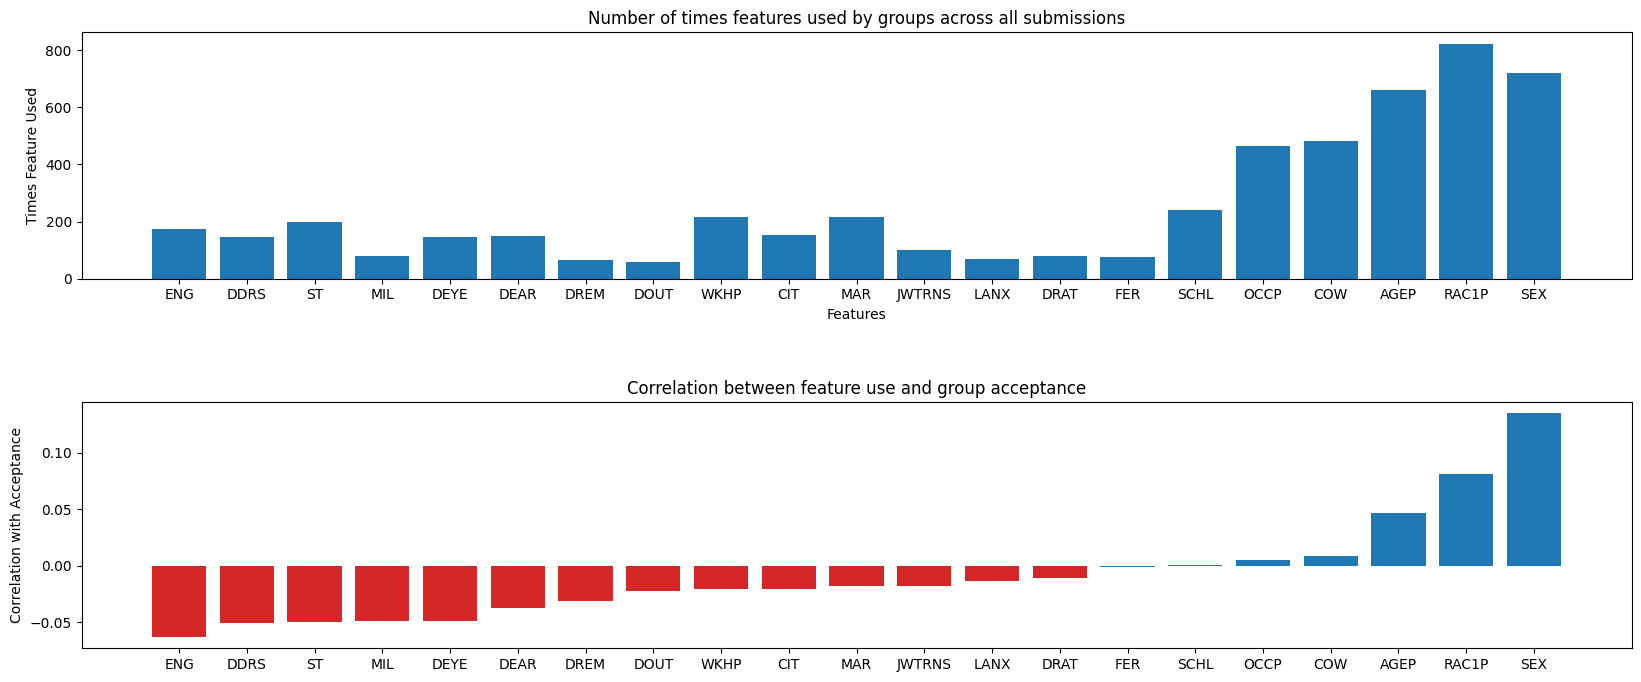

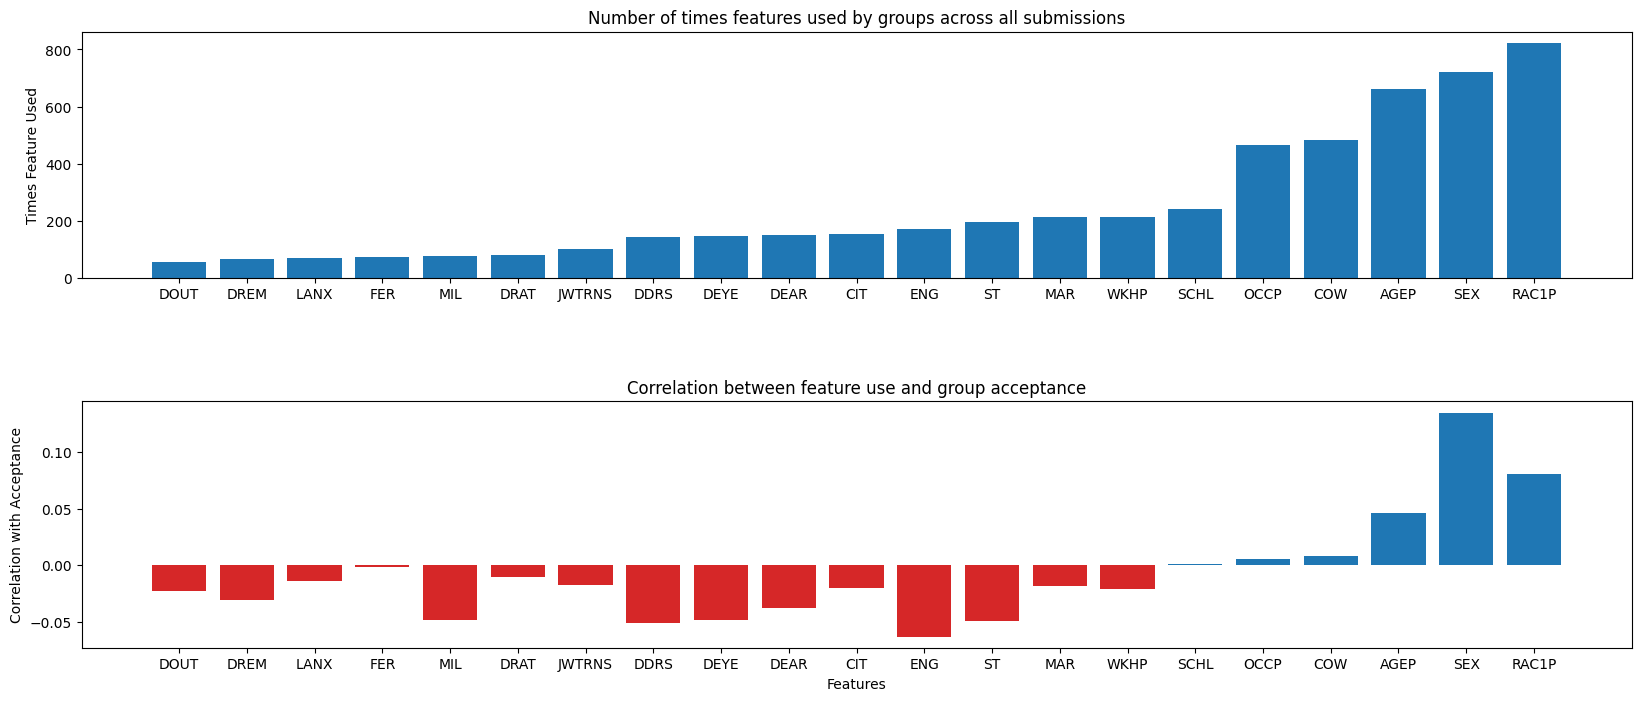

In [8]:
featureColumns =np.array(["ST","AGEP", "CIT","COW","DDRS","DEAR","DEYE","DOUT","DRAT","DREM","ENG","FER","JWTRNS","LANX","MAR","MIL","SCHL","SEX","WKHP","OCCP","RAC1P"])

data[featureColumns].sum(axis=0)
accepted_flag = (data["TF"]==True) | (data["GF"]==True)


correlations = data[featureColumns].apply(accepted_flag.corr, axis=0)

# plot sorting by correlation

#sort correlations by their magnitude
sortedIndices = correlations.argsort().tolist()
# find index of last negative-valued correlation
colorIndex = sum(correlations[sortedIndices]<0) - 1

plt.rcParams["figure.figsize"] = (20,8)
fig, (ax0, ax1) = plt.subplots(2, 1)
# plot correlations
ax1.bar(featureColumns[sortedIndices], correlations[sortedIndices], color = ['tab:red']*colorIndex + ['tab:blue']*(len(correlations)-colorIndex))
ax1.set(ylabel="Correlation with Acceptance", title='Correlation between feature use and group acceptance')
# plot group sizes
ax0.bar(featureColumns[sortedIndices], data[featureColumns[sortedIndices]].sum(axis=0))
ax0.set(xlabel="Features",ylabel="Times Feature Used", title='Number of times features used by groups across all submissions')
plt.subplots_adjust(hspace=0.5)
plt.savefig("fig/featureUse.png")

# plot sorting by number of times feature was used

# get indices of values sorted by size
indicesByCount = data[featureColumns[sortedIndices]].sum(axis=0).sort_values().index
# hardcoding in the index of the last negative correlation for ease (since all smaller groups have negative corr)
colorIndex = 15

plt.rcParams["figure.figsize"] = (20,8)
fig, (ax0, ax1) = plt.subplots(2, 1)
ax1.bar(indicesByCount, correlations[indicesByCount], color = ['tab:red']*colorIndex + ['tab:blue']*(len(correlations)-colorIndex))
ax1.set(xlabel="Features", ylabel="Correlation with Acceptance", title='Correlation between feature use and group acceptance')
ax0.bar(indicesByCount, data[indicesByCount].sum(axis=0))
ax0.set(ylabel="Times Feature Used", title='Number of times features used by groups across all submissions')
plt.subplots_adjust(hspace=0.5)
plt.savefig("fig/featureUse.png")


## Breakdown of use of feature space by groups

The dataset includes, per group submitted, 3 columns per feature. One is an indicator bit for if that feature was used, one is a string of just the operators (<=, etc) which were used for that group, and one of the numeric values that were used. E.g. if the group were "AGE > 25 & AGE <= 50", then the AGEV column has value 1, AGEO has value ">, <=", and AGEV has value "25,50". 

In [9]:
class featureDict:
    def __init__(self, featureName, cats, description, catNames=None):
        self.featureName = featureName
        self.cats = cats
        self.description = description
        self.visArray = []
        self.featureDataArray = []
        self.catNames = catNames

st = featureDict("ST", np.arange(1,73,1), "State and territory codes")
age = featureDict("AGEP", np.arange(105), "Age")
cit = featureDict("CIT", np.arange(5), "Citizenship status", ['US', 'US Terr', 'Abroad 2 Cit', 'Naturalized', 'Not Citizen'])
cow = featureDict("COW",  np.arange(10), "Class of worker", ["N/A", '4 Profit', 'Not4profit', 'Local Gov', 'State Gov', 'Fed gov', 'Self-employed', 'Self-emp inc', 'Unpayed', 'Unemployed'])
ddrs = featureDict("DDRS",  np.arange(3), "Self care difficulty", ['<5', 'Yes', 'No'])
dear = featureDict("DEAR",  np.arange(1,3), "Hearing difficulty", ['Yes', 'No'])
deye = featureDict("DEYE",  np.arange(1,3), "Vision difficulty", ['Yes', 'No'])
dout = featureDict("DOUT",  np.arange(3), "Independent living difficulty", ['<15', 'Yes', 'No'])
drat = featureDict("DRAT",  np.arange(7), "Veteran service connected disability rating", ['N/A', '0%', '10,20%', '30,40%', '50,60%', '70-100%', 'Unknown'])
drem = featureDict("DREM",  np.arange(3), "Cognitive difficulty", ['<5', 'Yes', 'No'])
eng = featureDict("ENG",  np.arange(5), "Ability to speak English", ['<5', 'V Well', 'Well', 'Not Well', 'None'])
fer = featureDict("FER",  np.arange(3), "Gave birth to child within the past 12 months", ['N/A', 'Yes', 'No'])
jwtrns = featureDict("JWTRNS",  np.arange(13), "Means of transportation to work", ['N/A', 'Car', 'Bus', 'Subway', 'Train', 'Trolley', 'Ferry', 'Taxi', 'Motorcycle', 'Bike', 'Walk', 'WFH', 'Other'])
lanx = featureDict("LANX",  np.arange(3), "Language other than English spoken at home", catNames=["<5", "Yes", "No"])
mar = featureDict("MAR",  np.arange(5), "Marital status", catNames=["Married", "Widowed", "Divorced", "Separated", "Never"])
mil = featureDict("MIL",  np.arange(5), "Military service", catNames=["<17", "Active", "Past active", "Reserves", "Civilian"])
schl = featureDict("SCHL",  np.arange(25), "Educational attainment")
sex = featureDict("SEX",  np.arange(1,3), "Binary sex", catNames=["Male", "Female"])
wkhp = featureDict("WKHP",  np.arange(101), "Usual hours worked per week past 12 months")
occp = featureDict("OCCP",  np.arange(10000), "Occupation code")
rac1p = featureDict("RAC1P",  np.arange(1,10), "Race code", catNames=['White', 'AA', 'AI', 'AN', 'Spec. Tribe', 'Asian', 'Pacific Islander', 'Other', '2+'])

features = [st, age, cit, cow, ddrs, dear, deye, dout, drat, drem, eng, fer, jwtrns, lanx, mar, mil, schl, sex, wkhp, occp, rac1p]


def checkEnd(end, featureVector):
    # helper code that checks if someone has a delimeter that is out of bounds, e.g. AGE < 10000 would push 10000 to 105 which is max age. 
    maxRange = featureVector.shape[1] - 1
    if end > maxRange:
        end = maxRange
    return end

def isFloat(str):
    # helper to check if can convert str to float
    try:
        float(str)
    except ValueError:
        return False
    return True
    

### Generates a matrix ('visArray') for each feature, where a row in matrix is a single submission. Each row is a 1 hot encoding of the region of the feature space used. 
# e.g. for age, the visArray has 105 columns. 
# if the group specified was AGE > 25 & AGE <= 50, then columns 25 through 50 would have a 1 in them for that row, and everywhere else is a 0.
# or if the group specified was AGE == 10 | AGE > 25 & AGE <= 50, then it would be the same but also have a 1 in the 10th column. 
# this matrix is then used to build a heat map of all the groups submitted that use that feature. 

for feature in features:
    
    featureName = feature.featureName
    #print(featureName)
    opString = feature.featureName + 'O' #name of column in dataframe that has operation code. If the group was AGE == 10 | AGE > 25 & AGE <= 50 this would look like ==,|, &
    valStr = feature.featureName + 'V'  #name of column in dataframe that has value code. If the group was AGE == 10 | AGE > 25 & AGE <= 50 this would look like 10, 25, 50

    featureCats = feature.cats # vector of all possible categories. In age example, this is an array of ints 0 through 105. 
    featureData = data[data[featureName]==True].reset_index(drop=True) # all the submitted groups that used the feature of interest
    feature.featureDataArray = featureData # storing it for later inspection

    visArray = np.zeros((len(featureData), len(featureCats))) # initializing the matrix that will be used for the heatmap visualization.

    def fillVisArray(row): 
        # function to fill in the visualization matrix
        # will be called using pandas.apply, so takes in a single row of the dataframe as a series object. 

        idx = row.name # index of row in dataframe. weirdly, when a row is passed in as a series object, its index in the original dataframe is passed as the name of the series. 
        
        if isinstance(row[opString], str): #removing things w parsing errors
            #print(featureName, idx)
            #print(row['GrCo'])
            #print('a')
            opArr = row[opString].split(',') # split operation string by commas. 
            #print('b')
            #print('valstr', row[valStr])
            #print('valstr type', type(row[valStr]))
            valArr = row[valStr].split(',') 
            #print('c')
            
            if len(valArr)!=len(opArr): # check for parsing error
                #print(valArr, opArr)
                return None
            
            for s in valArr: # check for weird values that can't be converted, e.g. "3.0.4" 
                    if not isFloat(s):
                        return None
            
            # there are no cases where people use both == and <=/>=, so can treat them independently

            if opArr[0] == "==" :
                # print('idx', idx)
                # print(opArr)
                # print(valArr)
                
                # tossing out values that are beyond range 
                for s in valArr:
                    if int(float(s)) < 0 or int(float(s)) >= len(featureCats):
                        return None 
                
                
                visArray[[idx],[int(float(s)) for s in valArr]] = [1]*len(valArr)
            
            # now, parsing <= and >=. Assuming here that if you have the two operations next to each other, that they were anded together. which could actually not be the case.

            start = 0
            end = len(featureCats)

            for i in range(len(opArr)):
                
                # all indices reindexed since codes are indexed by 1 not 0.
                if opArr[i] == "<=":
                    end = int(float(valArr[i]))-1
                    
                    end = checkEnd(end, visArray)
                    visArray[idx,start:end+1] = [1]*(end-start+1)

                elif opArr[i] == "<":
                    end = int(float(valArr[i]))-2
                    end = checkEnd(end, visArray)
                    visArray[idx,start:end+1] = [1]*(end-start+1)

                elif opArr[i] == ">=":
                    if int(float(valArr[i])) != 0:
                        start =  int(float(valArr[i]))-1
                    else:
                        start = 0
                    
                    if i==len(opArr)-1:
                        end = len(featureCats)
                        visArray[idx,start:end] = [1]*(end-start)

                elif opArr[i] == ">":
                    start = int(float(valArr[i]))
                    if i==len(opArr)-1:
                        end = len(featureCats)
                        visArray[idx,start:end] = [1]*(end-start)

    featureData.apply(fillVisArray, axis=1)
    feature.visArray = visArray

# weird thing for state codes to deal w how cats jump from 56 to 72
# to do: make it only plot the particular states that were actually included in the feature selection
i = np.arange(0,57)
i[-1] = -1
st.visArray = st.visArray[:,i]

Generating the actual heatmaps

/var/folders/92/why7bd2s0cl4zpsp9bgrg4dw0000gn/T/ipykernel_69224/1285705774.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,10))


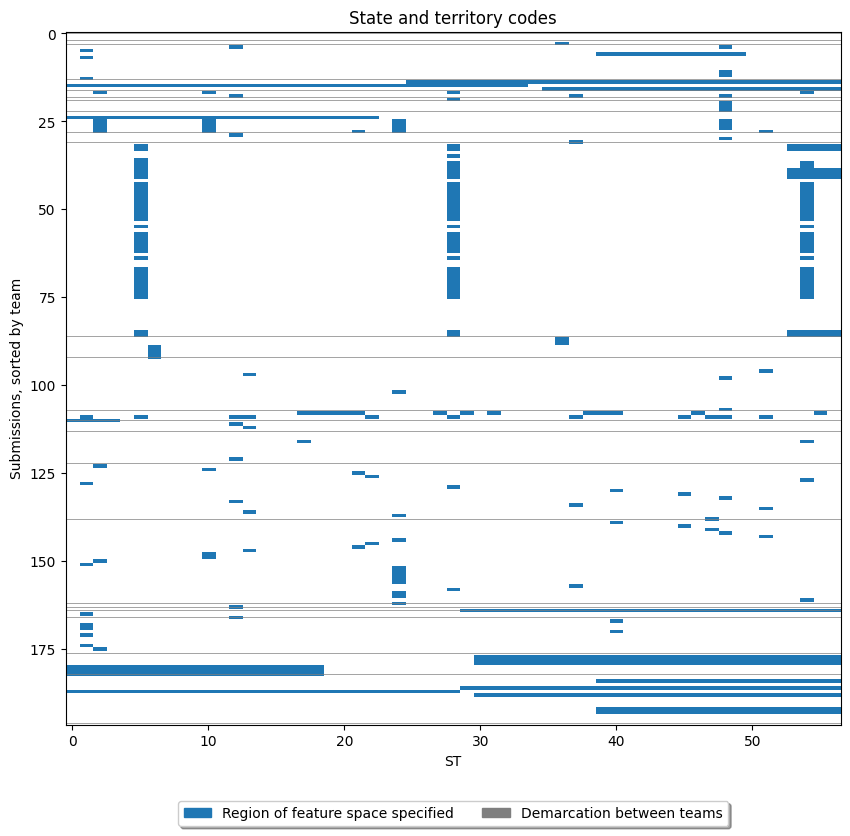

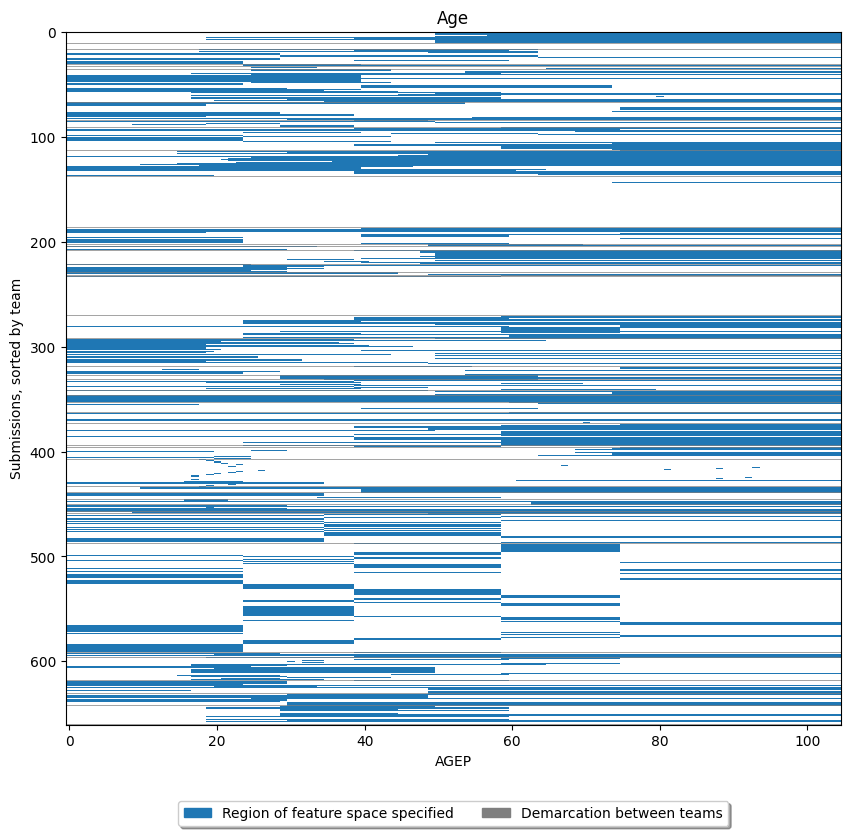

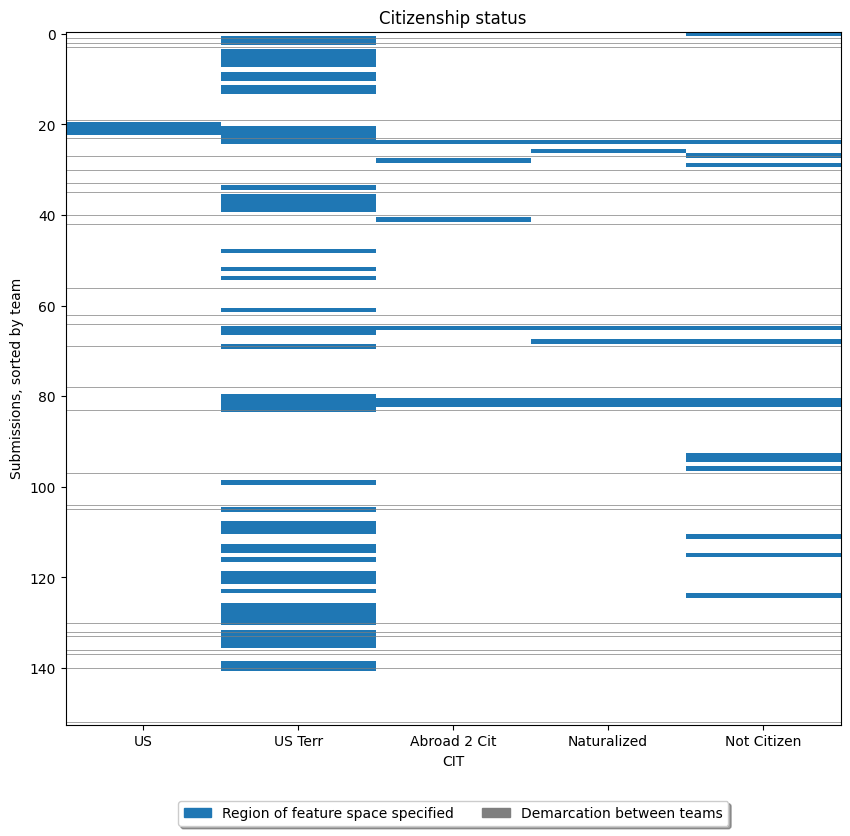

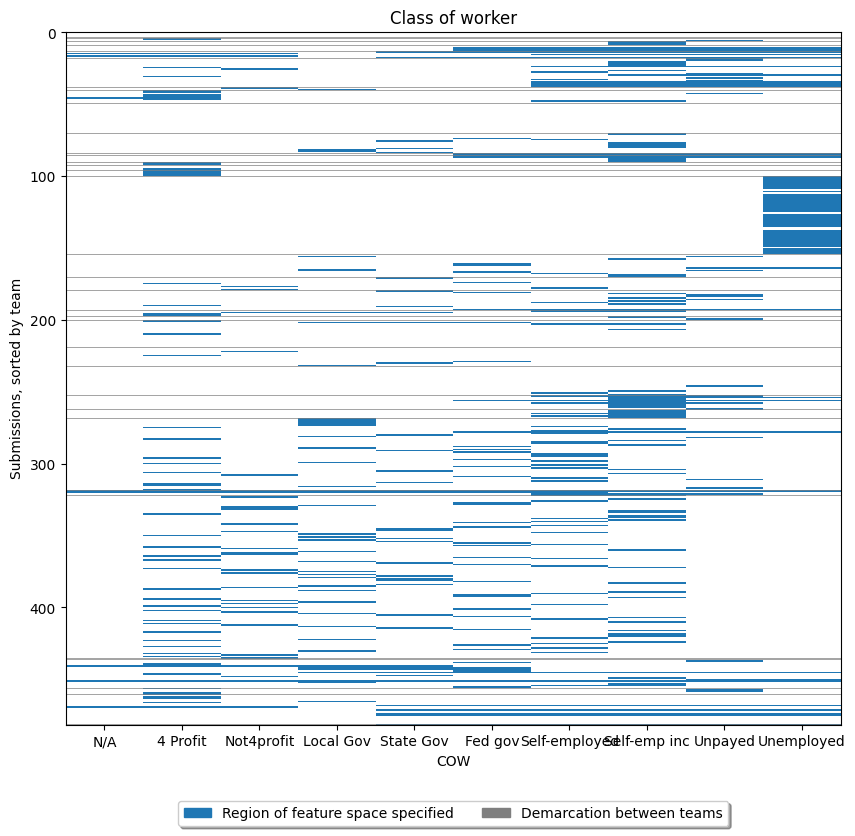

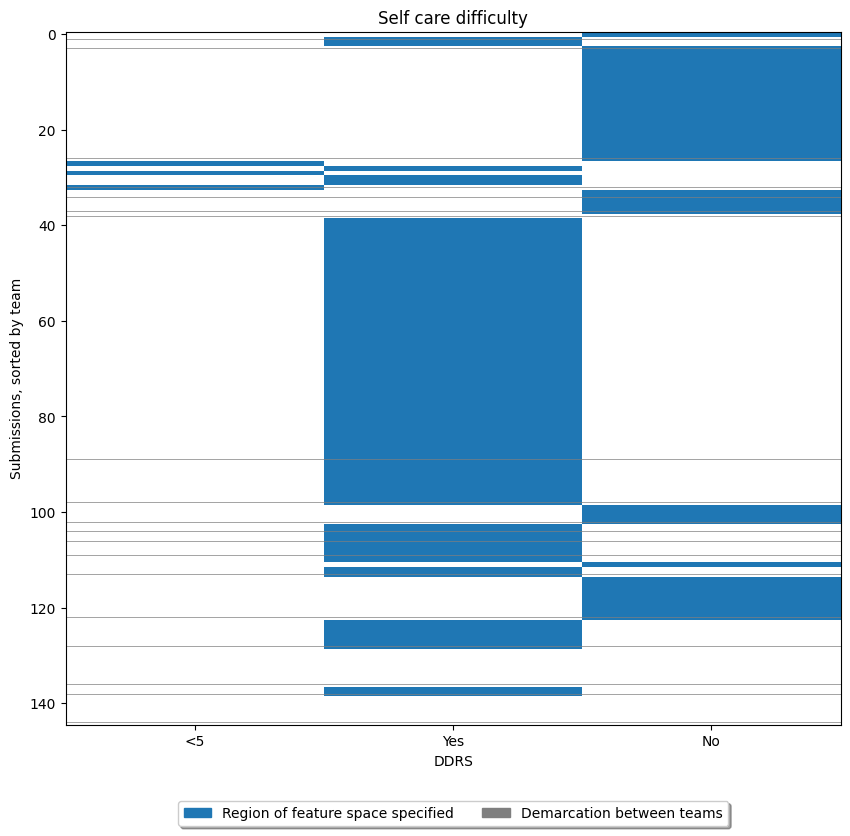

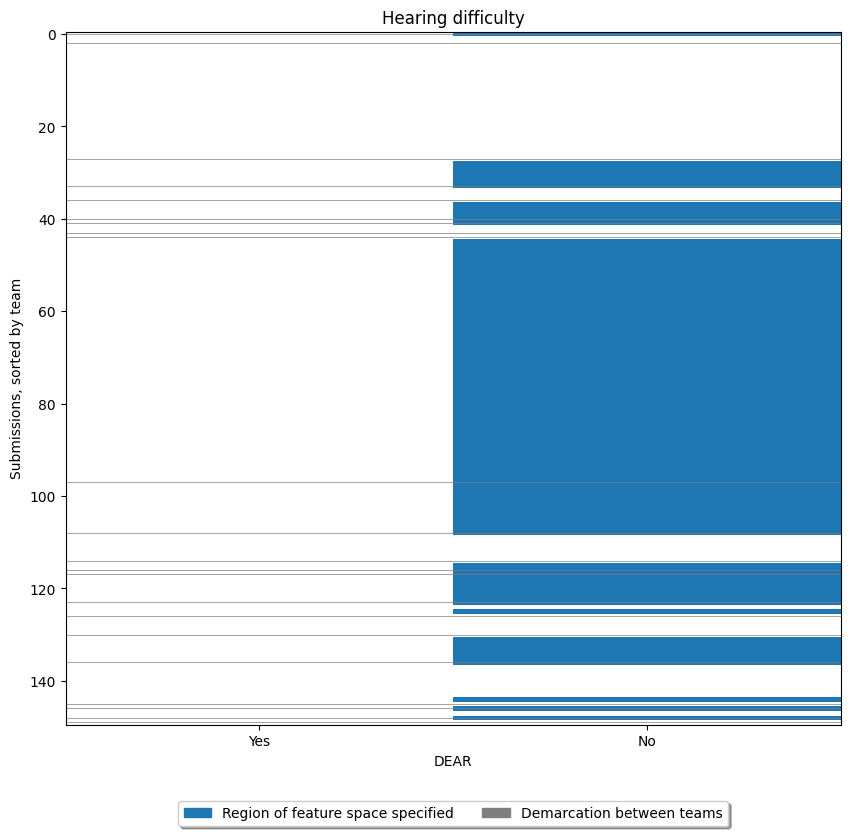

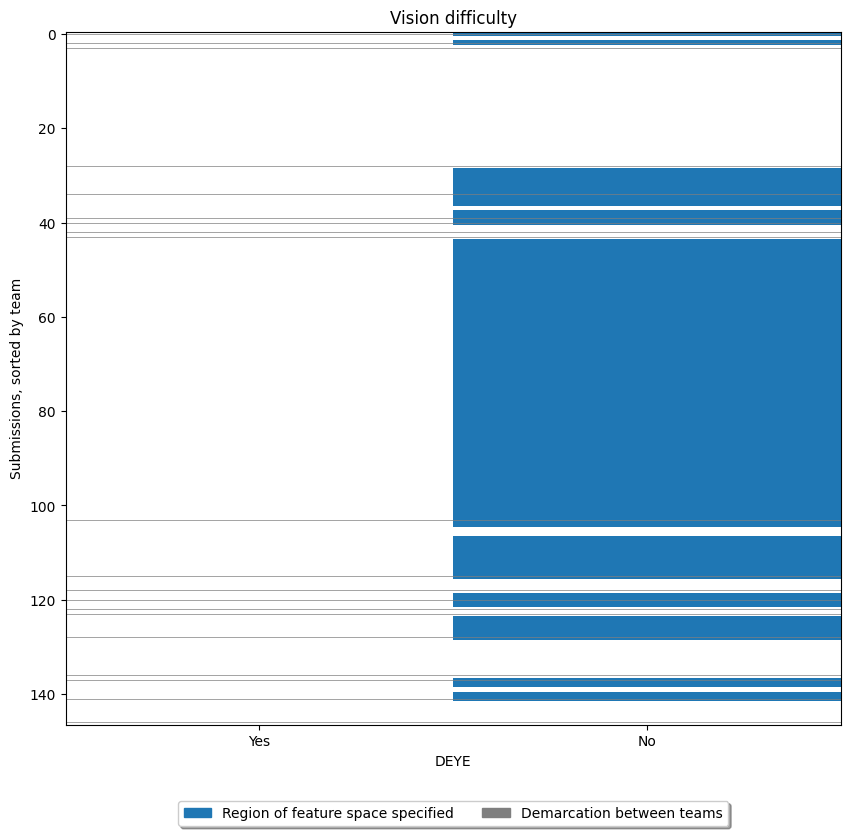

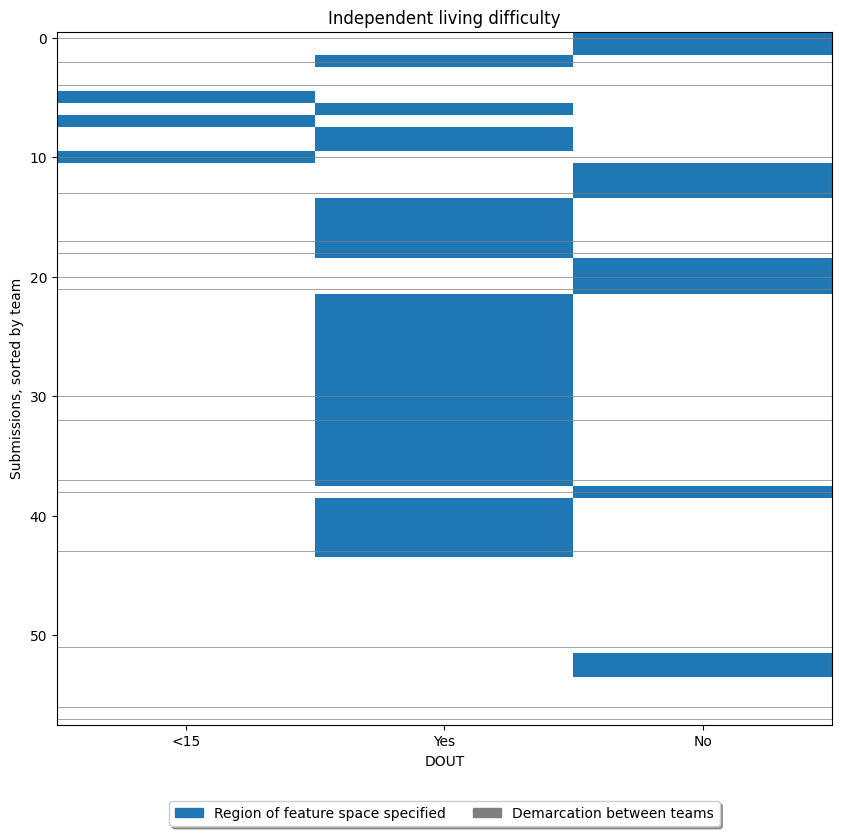

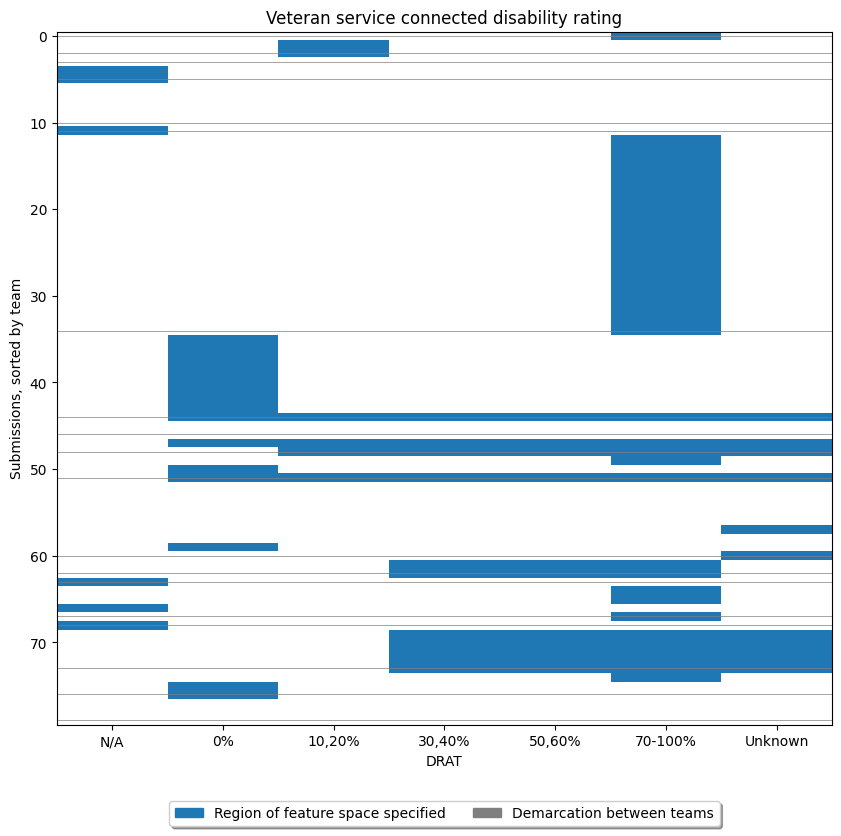

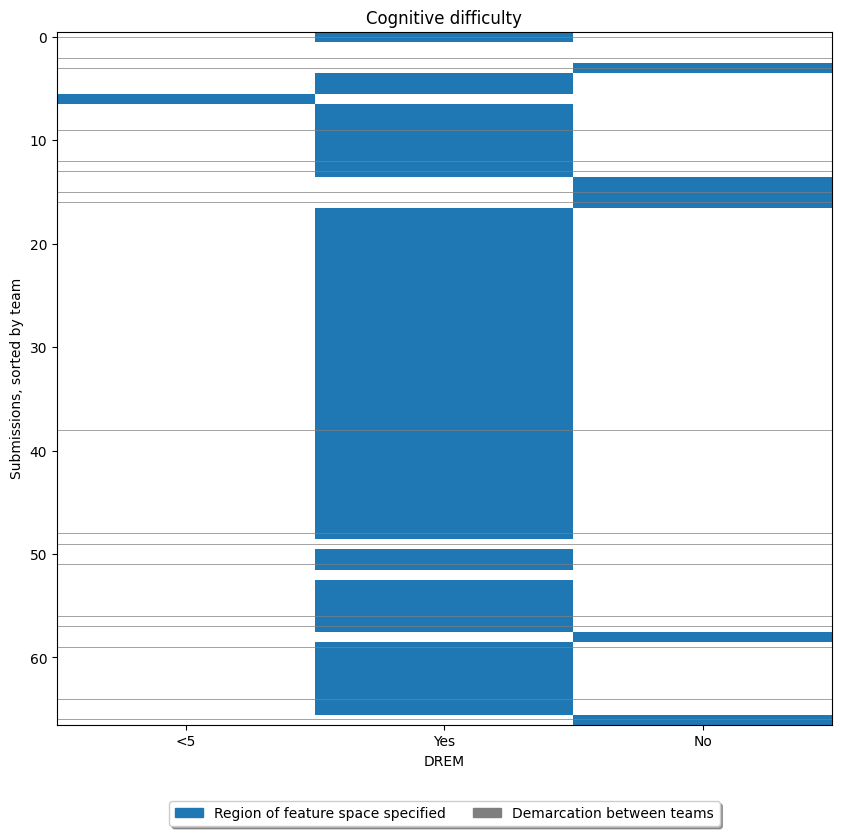

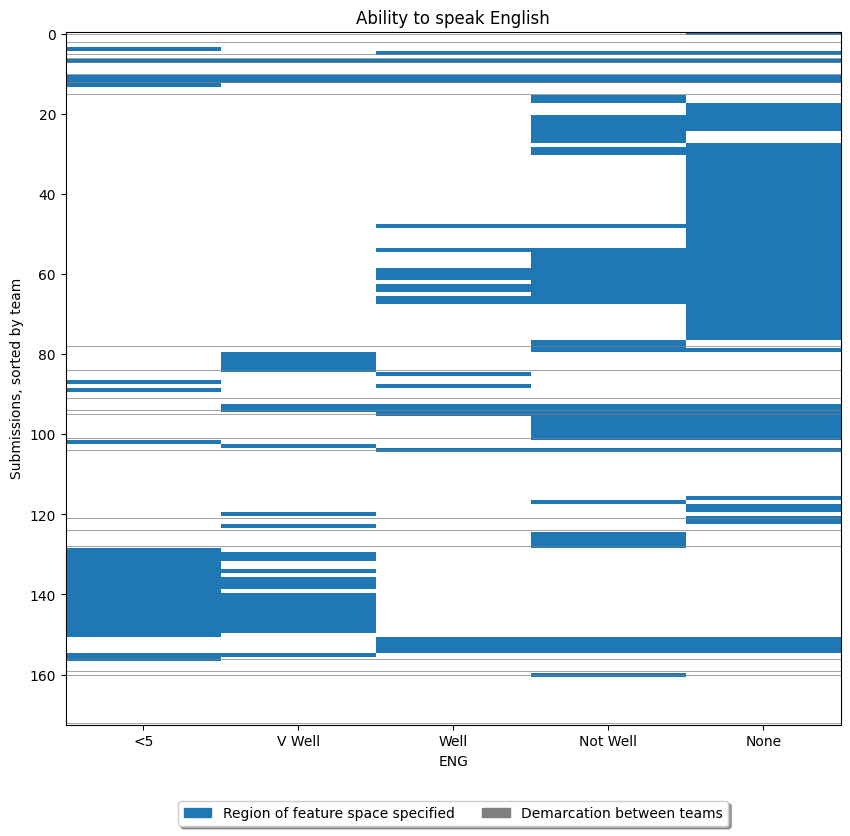

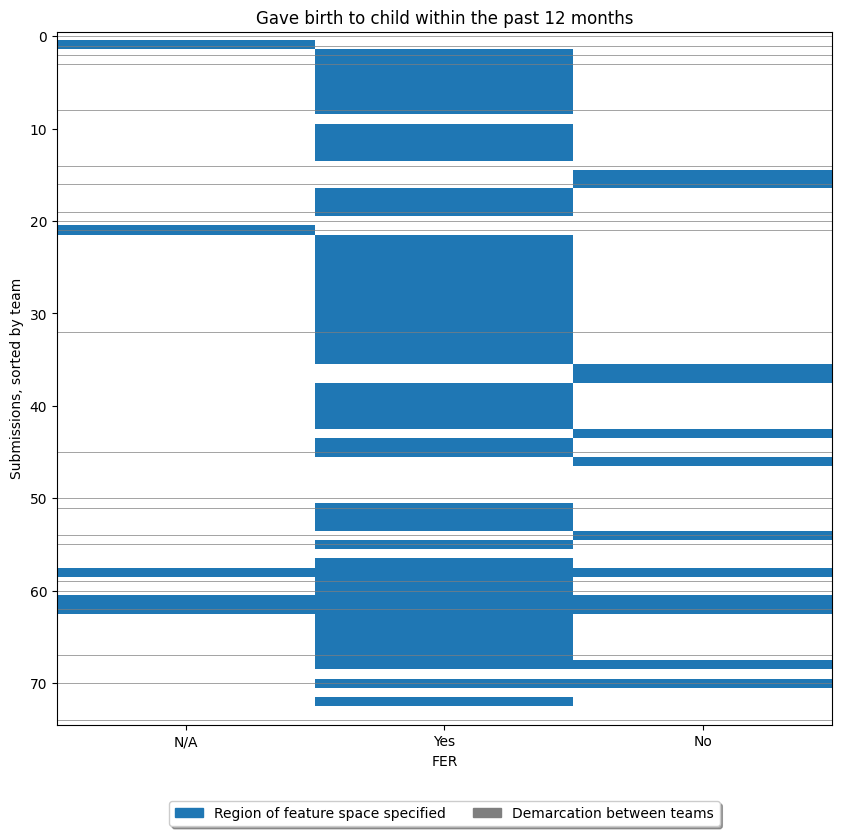

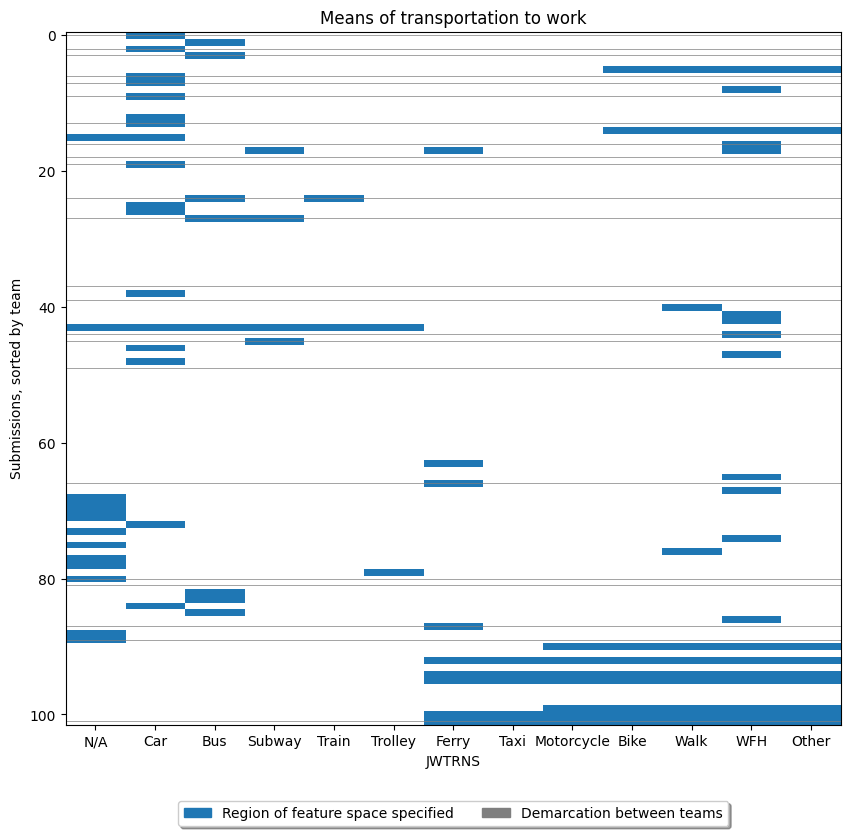

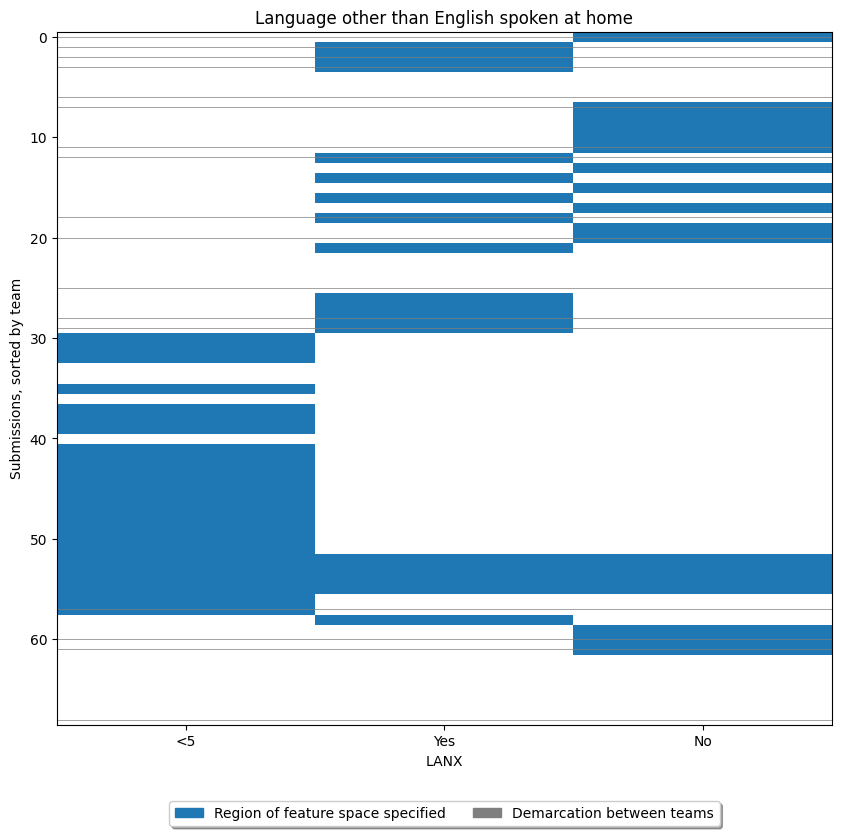

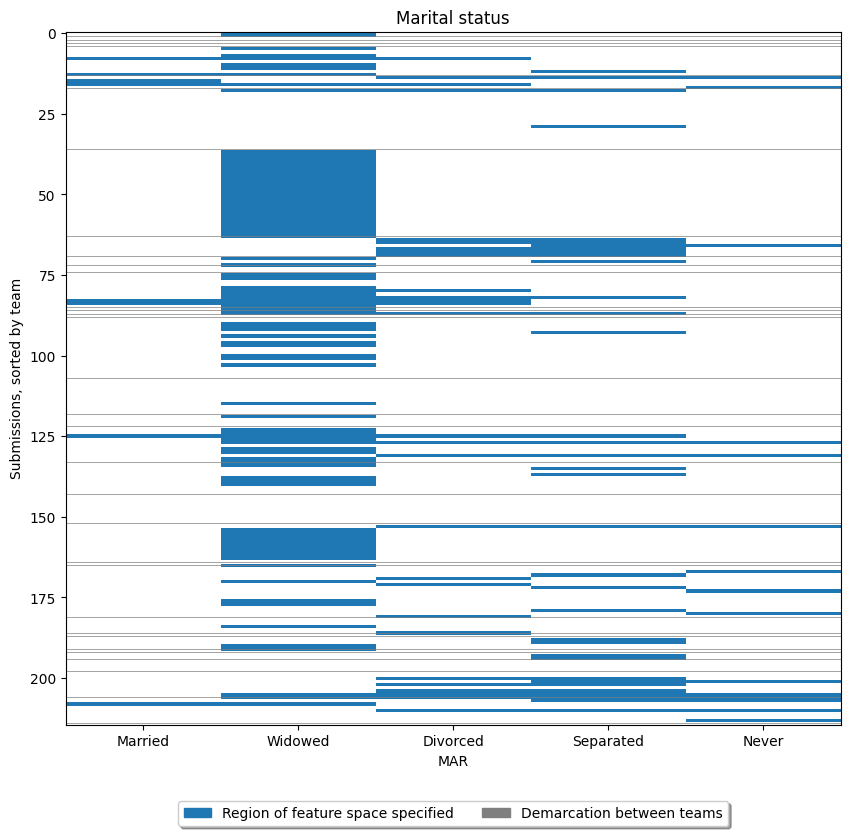

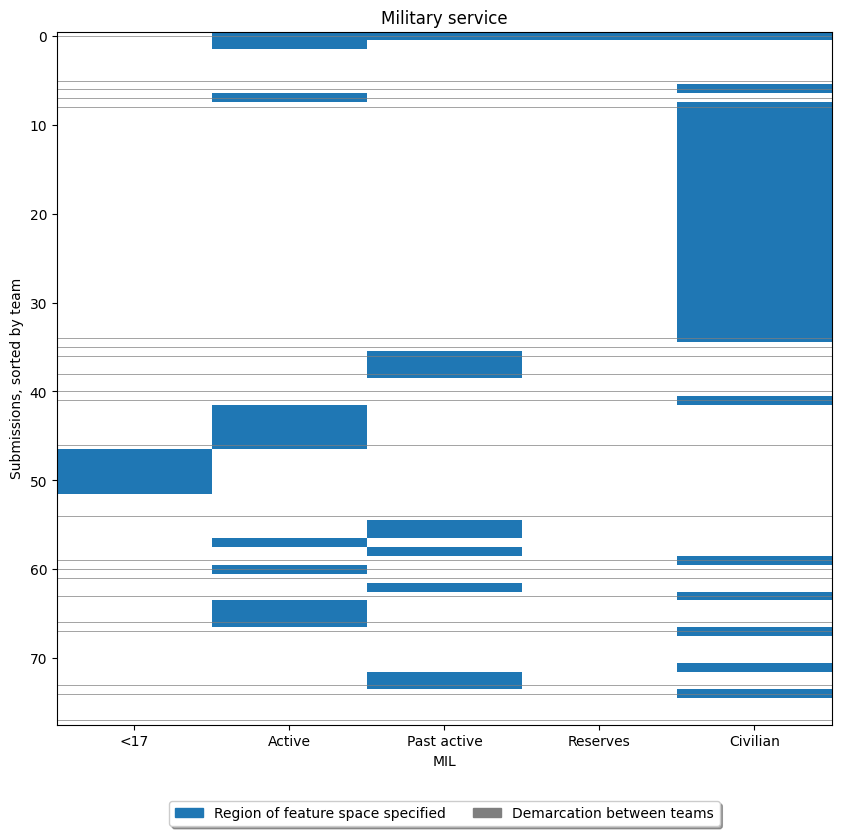

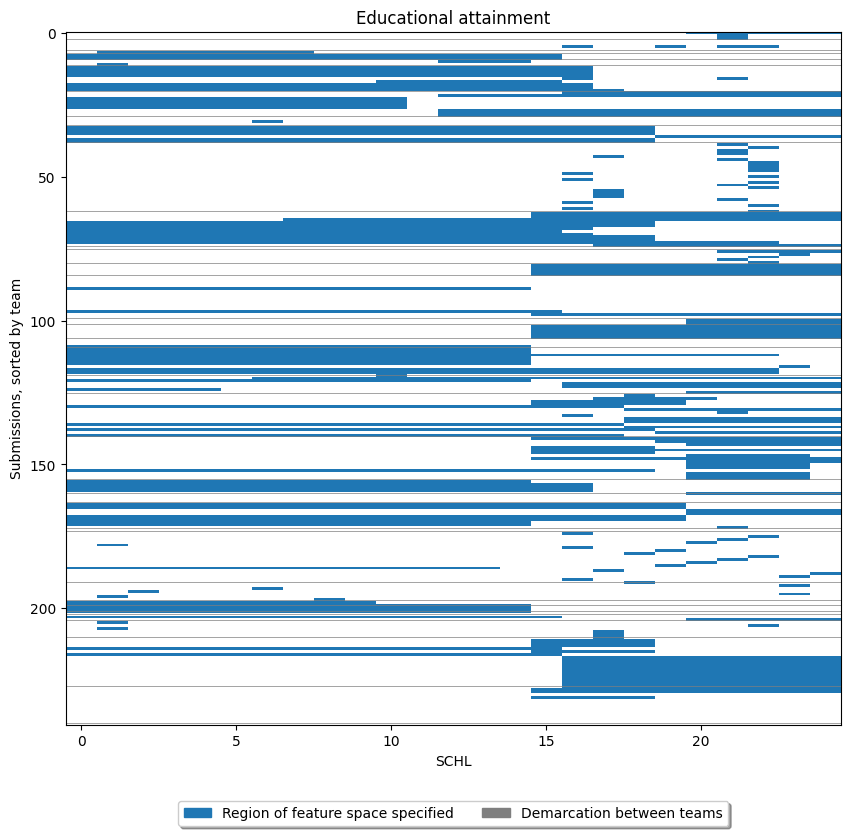

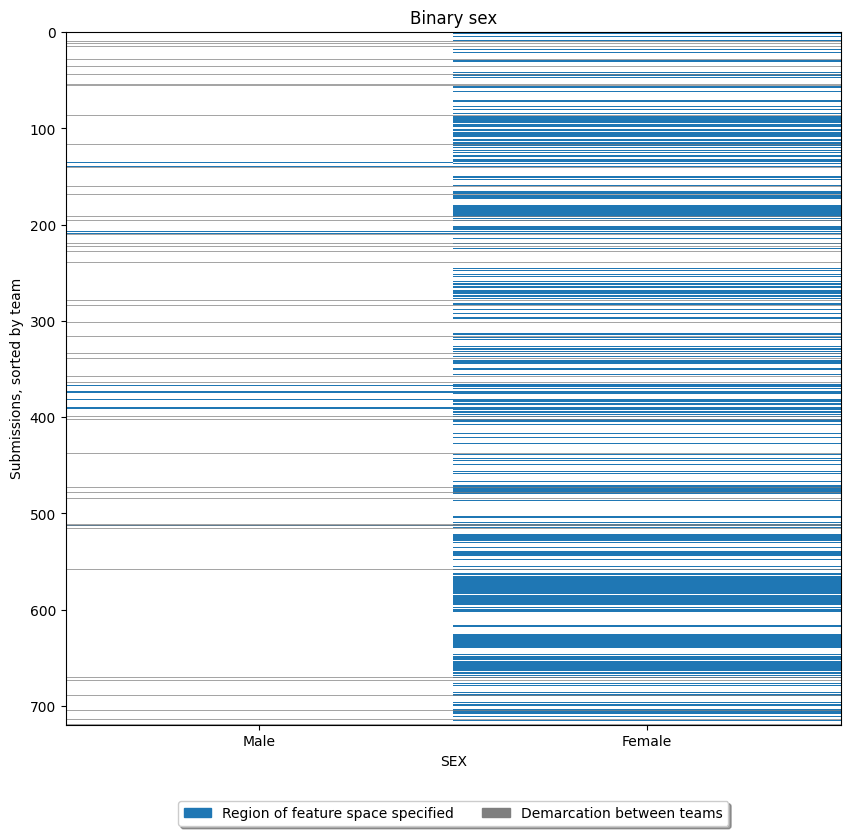

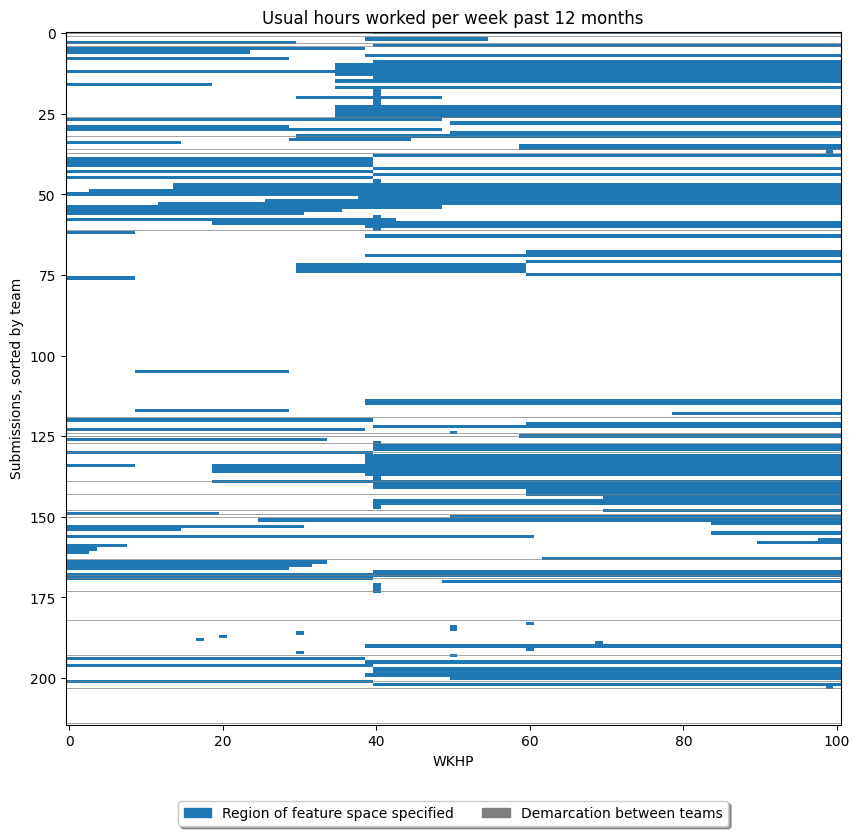

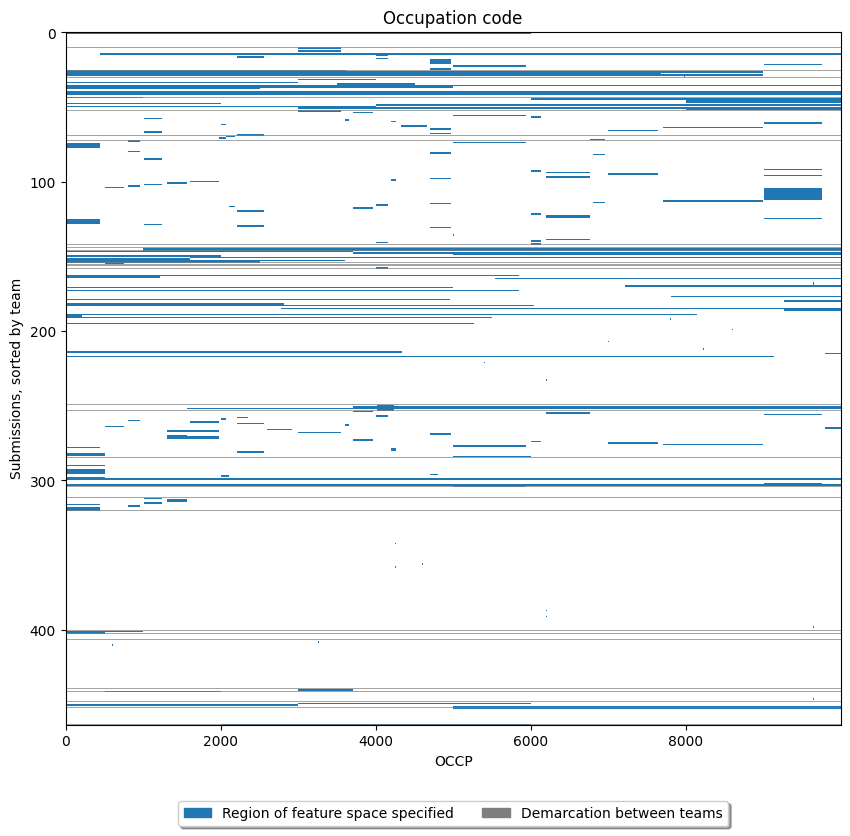

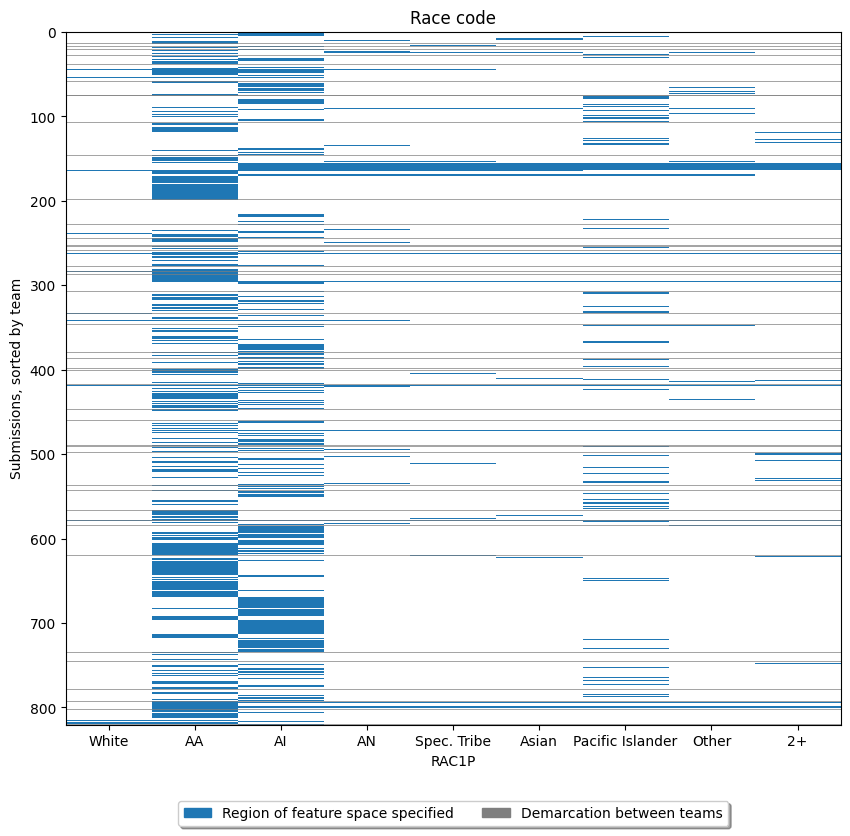

In [11]:
# generating heatmaps

for feature in features:

    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)

    cmap = colors.ListedColormap(['white', 'tab:blue'])
    ax.imshow(feature.visArray, cmap=cmap, aspect='auto', interpolation='nearest')

    groupBoundaries = feature.featureDataArray[~feature.featureDataArray.duplicated(subset='TID', keep='last')].index

    [ax.axhline(y=b, color='tab:gray', linewidth=0.5) for b in groupBoundaries]

    plt.xlabel(feature.featureName)
    plt.ylabel('Submissions, sorted by team');
    plt.title(feature.description)

    if feature.catNames is not None:
        plt.xticks(ticks=np.arange(len(feature.catNames)), labels=feature.catNames);

    blue_patch = mpatches.Patch(color='tab:blue', label='Region of feature space specified')
    gray_patch = mpatches.Patch(color='tab:gray', label='Demarcation between teams')

    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(handles=[blue_patch, gray_patch], loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=5)

    #plt.title("Submissions' use of state codes in group description");
    plt.savefig('fig/featurevis/%s.png'%feature.featureName)

Rather than looking at heatmaps by submission, here's a simpler visualization that just says which categories were used per feature, over all submissions that used the feature. 

/var/folders/92/why7bd2s0cl4zpsp9bgrg4dw0000gn/T/ipykernel_69224/1717630548.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,10))


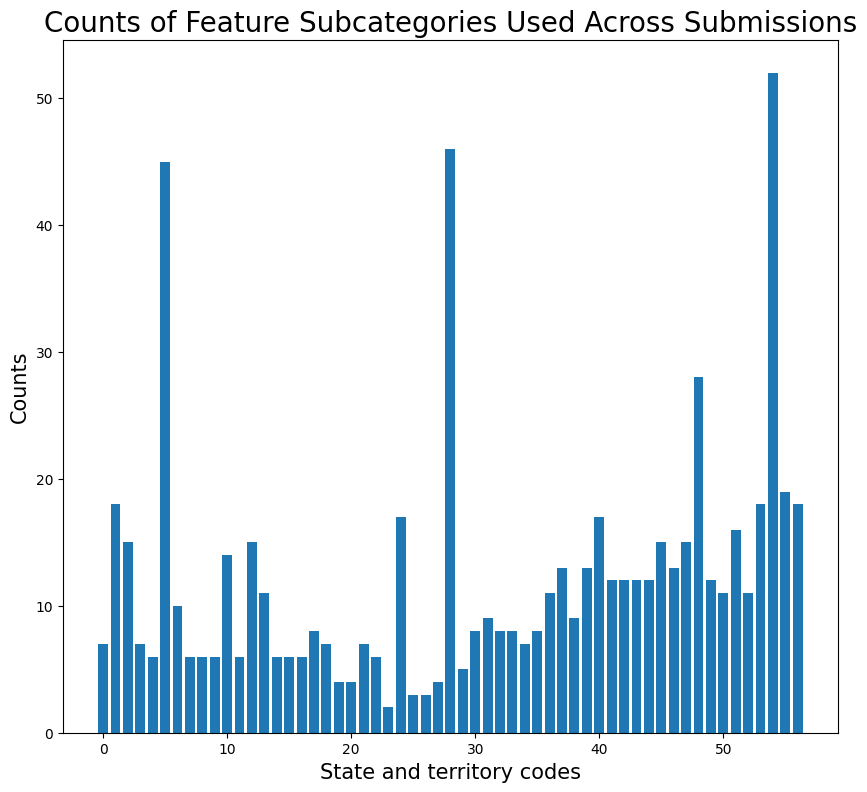

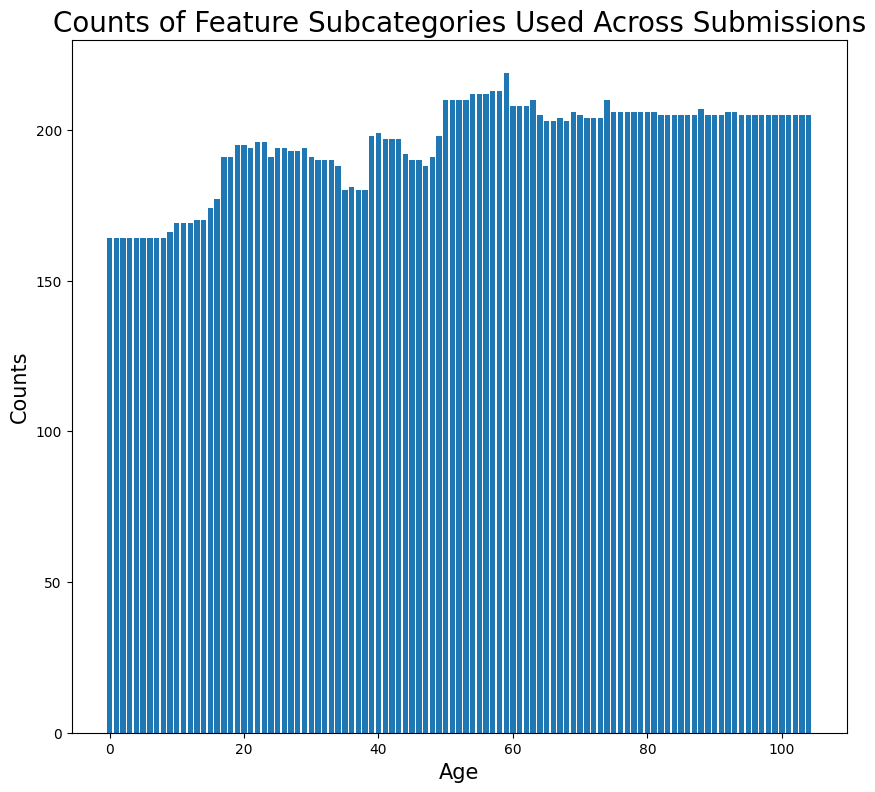

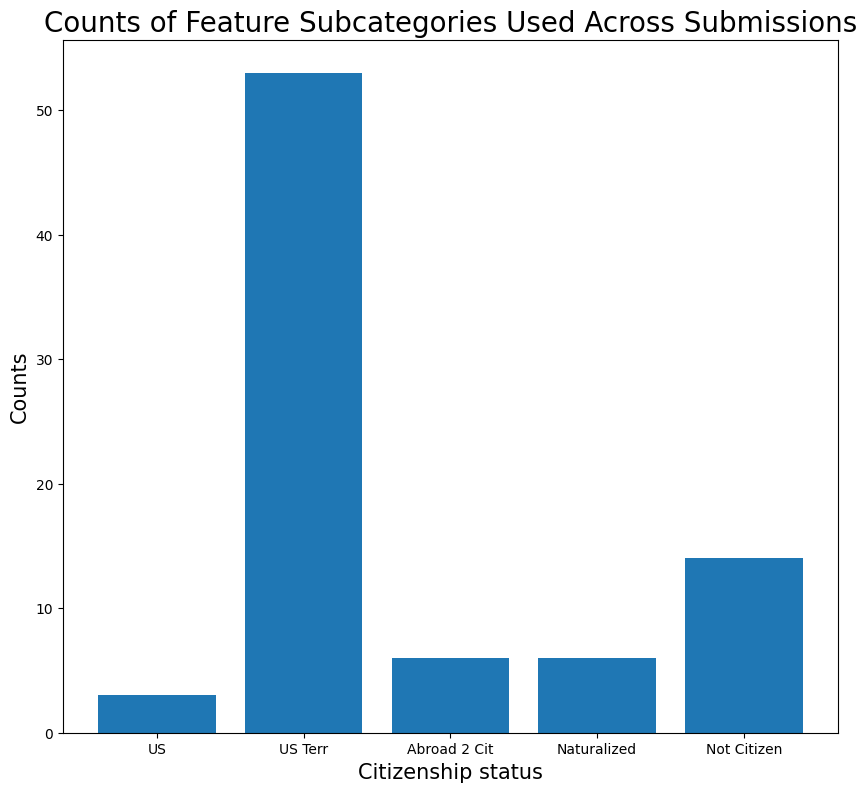

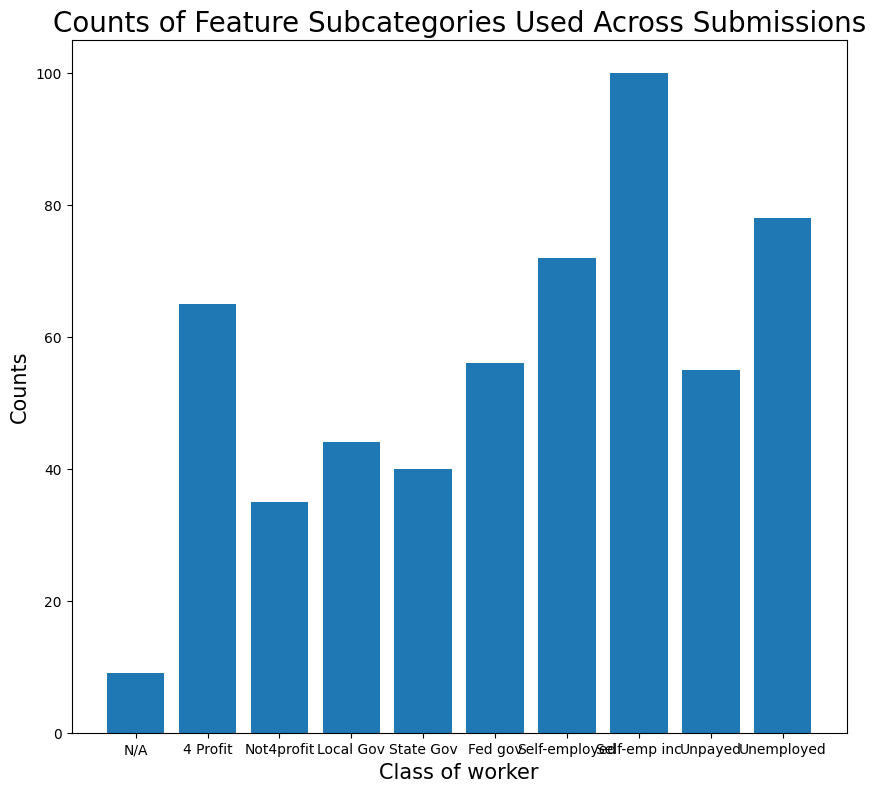

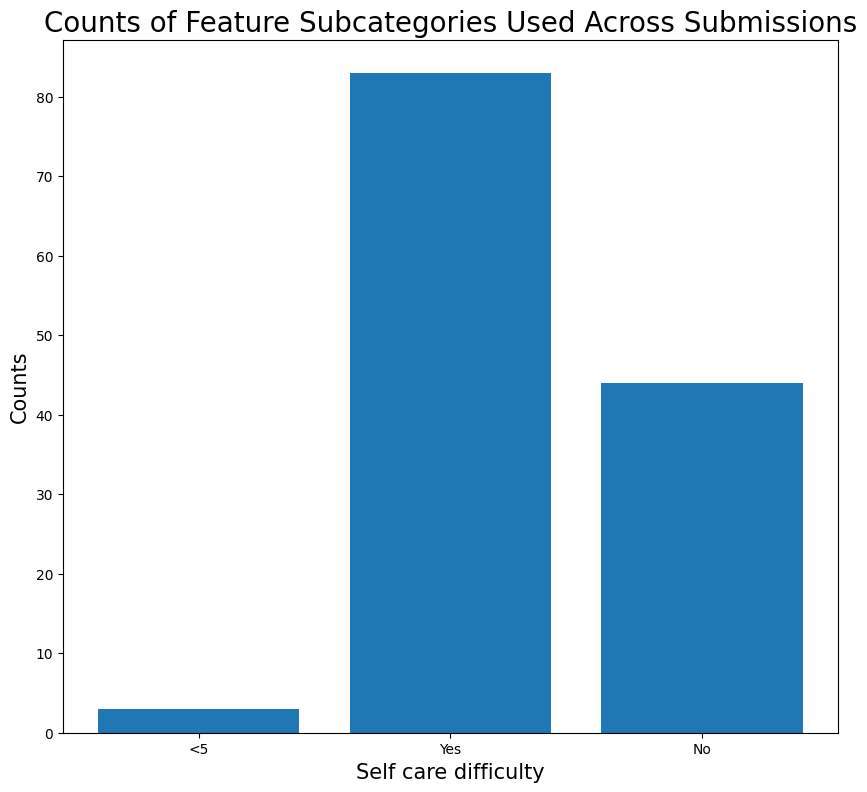

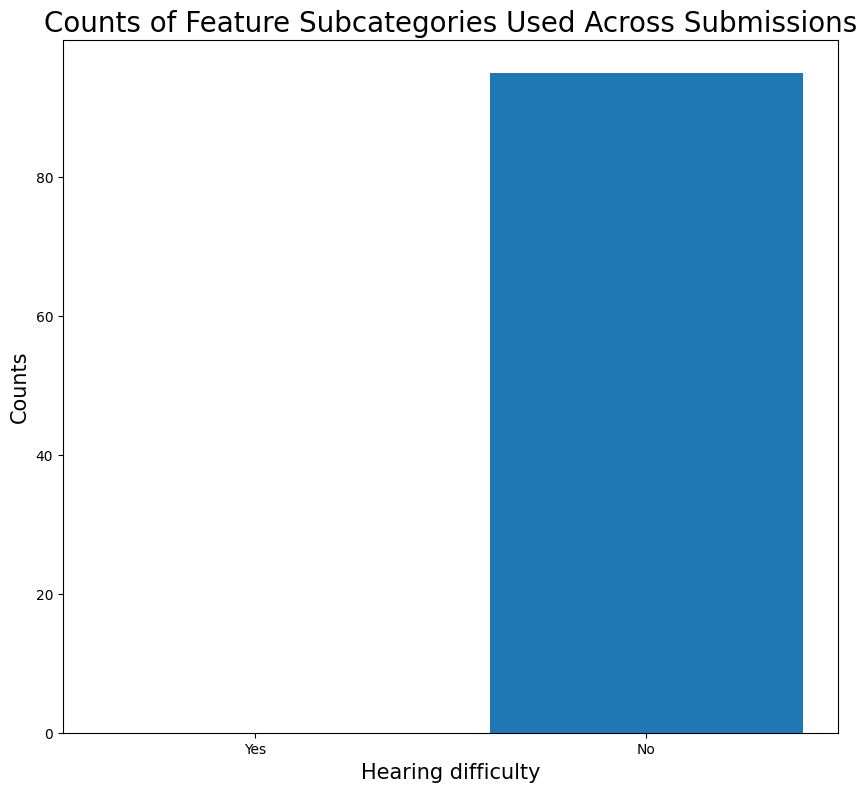

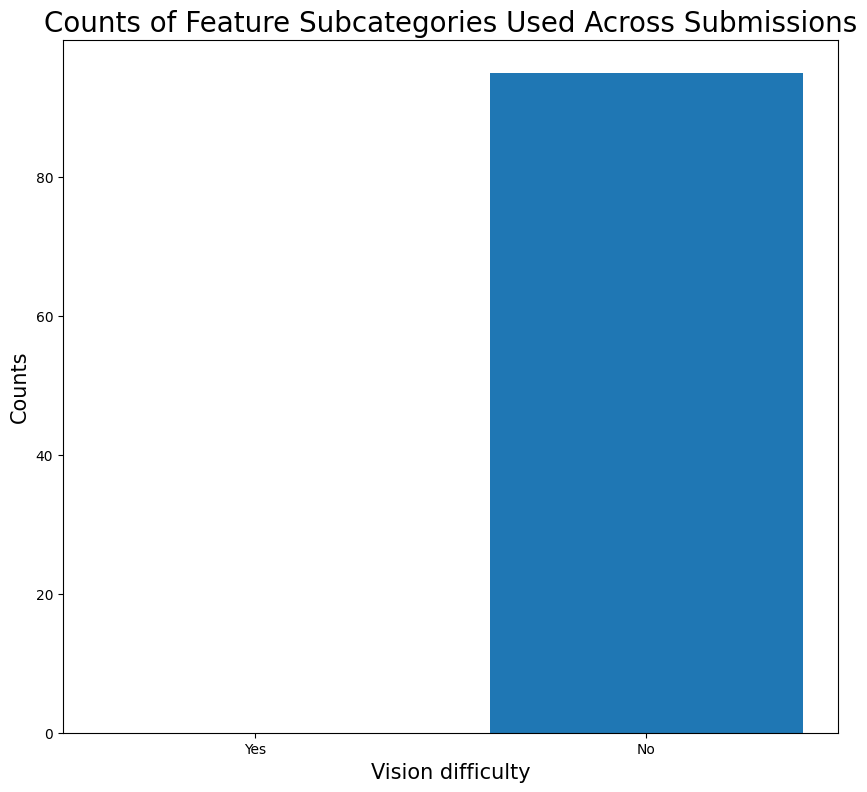

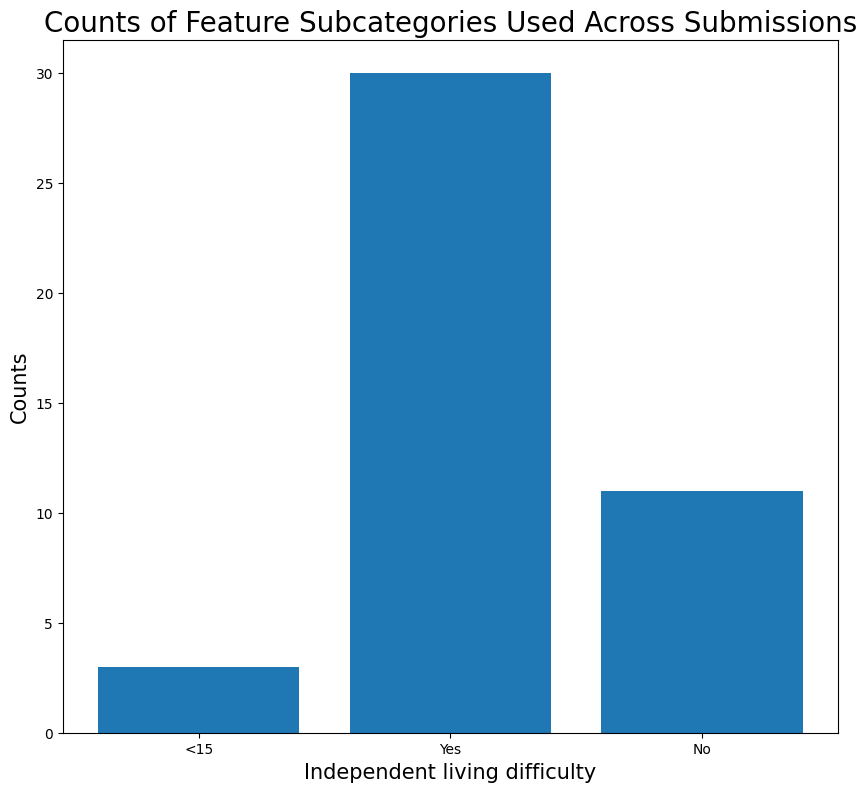

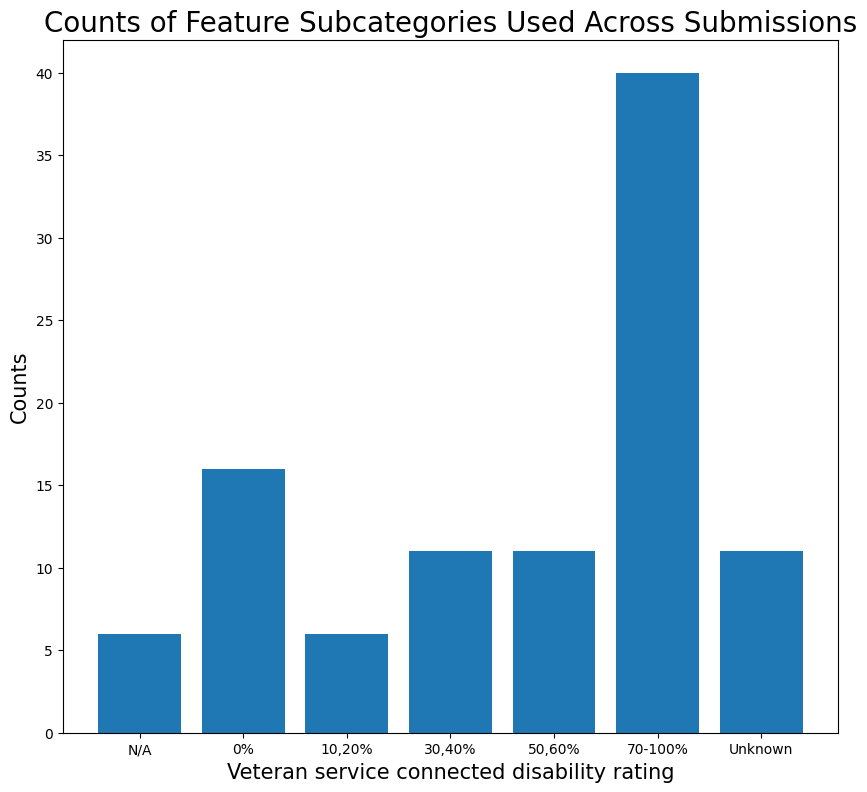

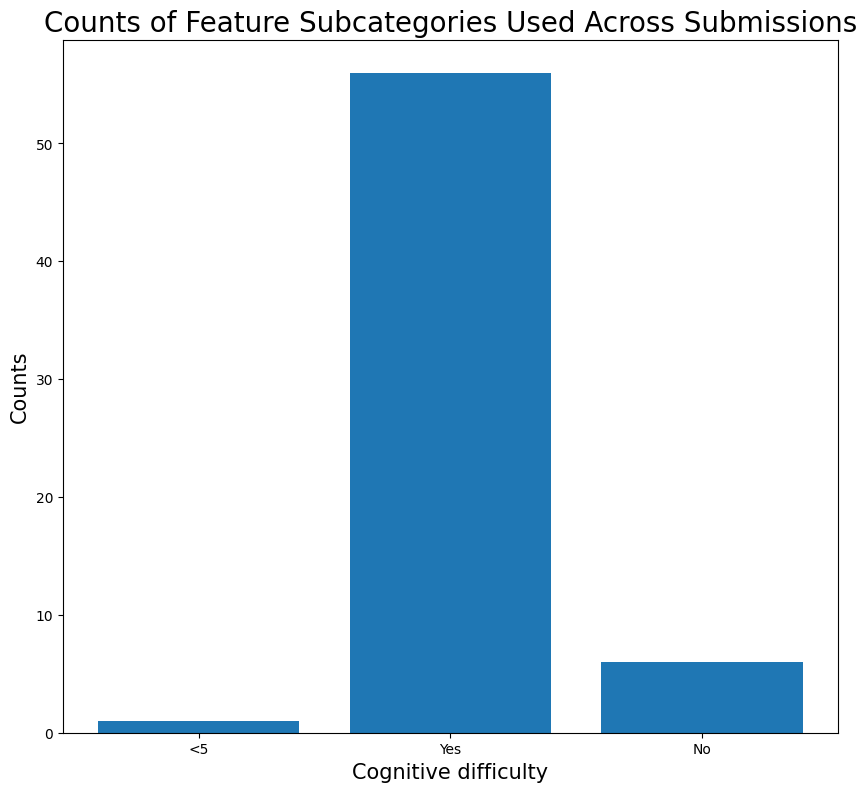

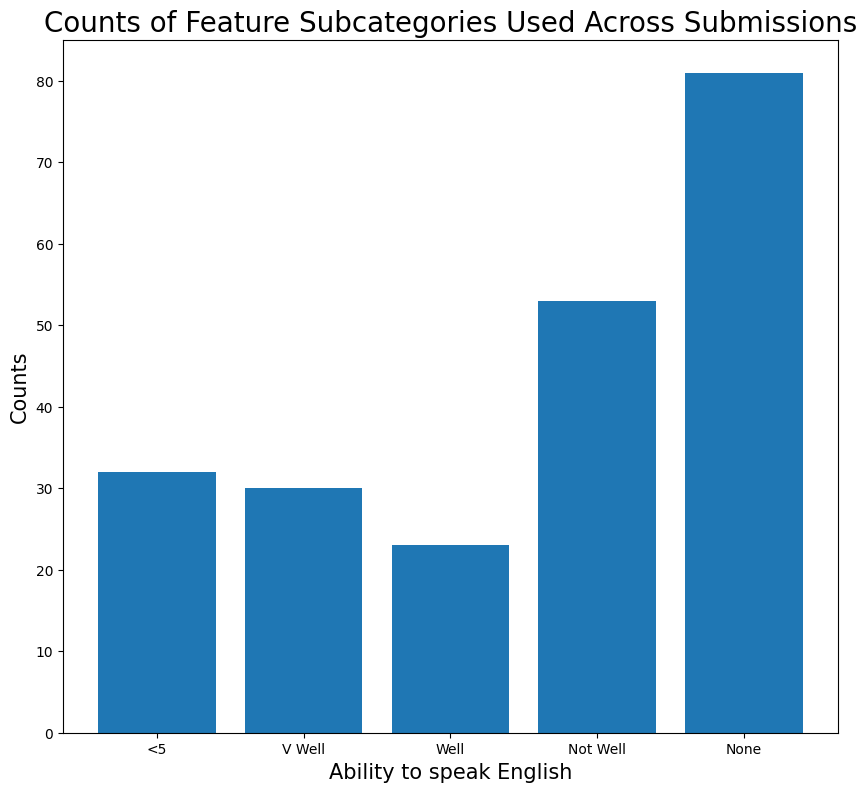

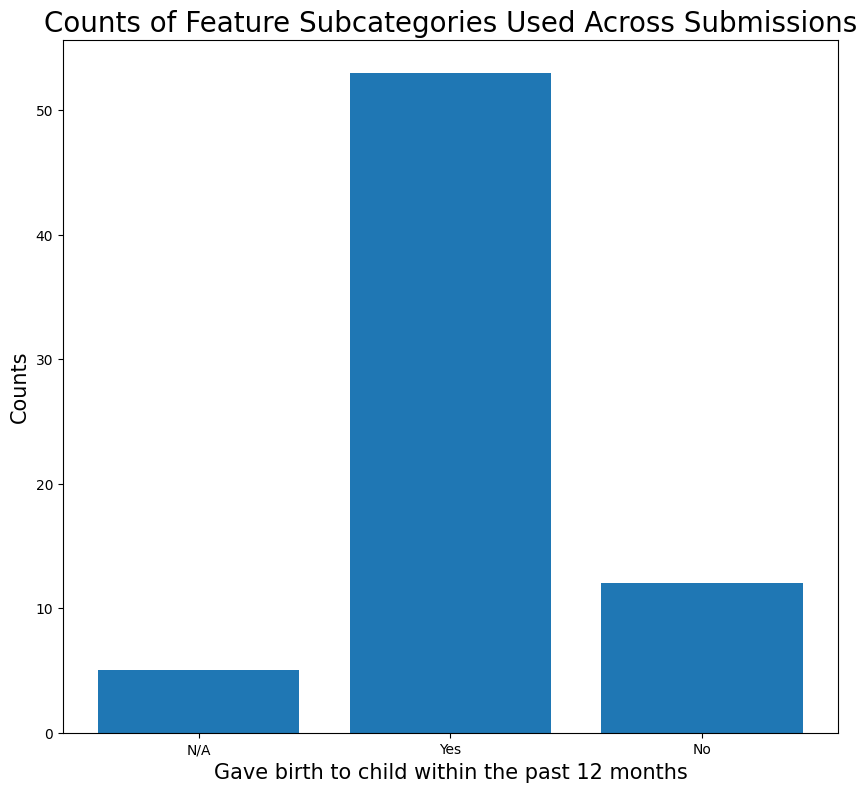

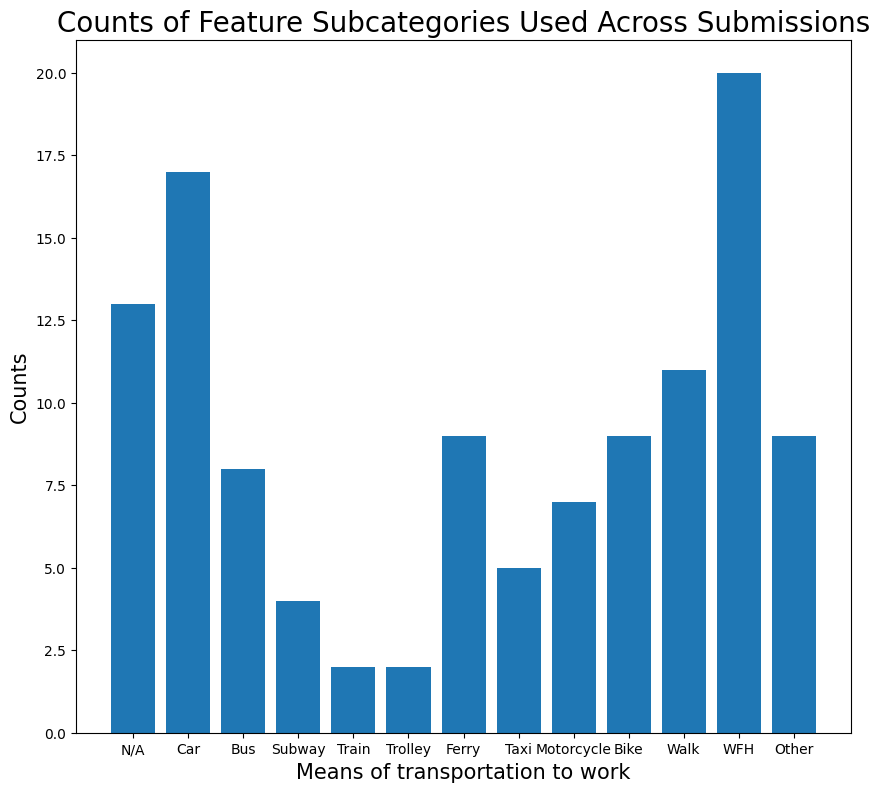

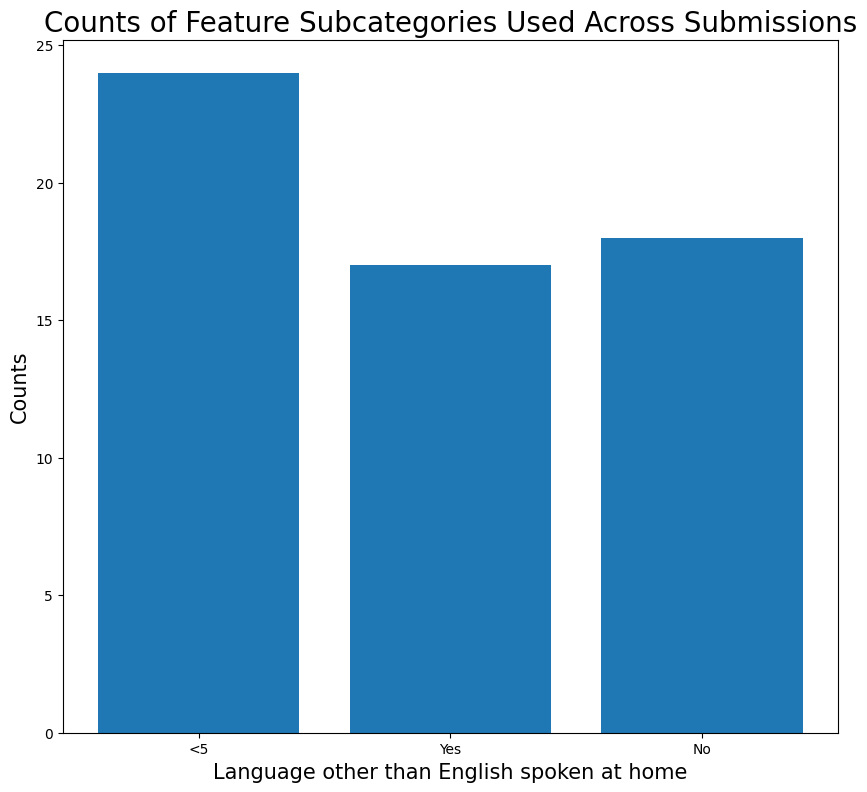

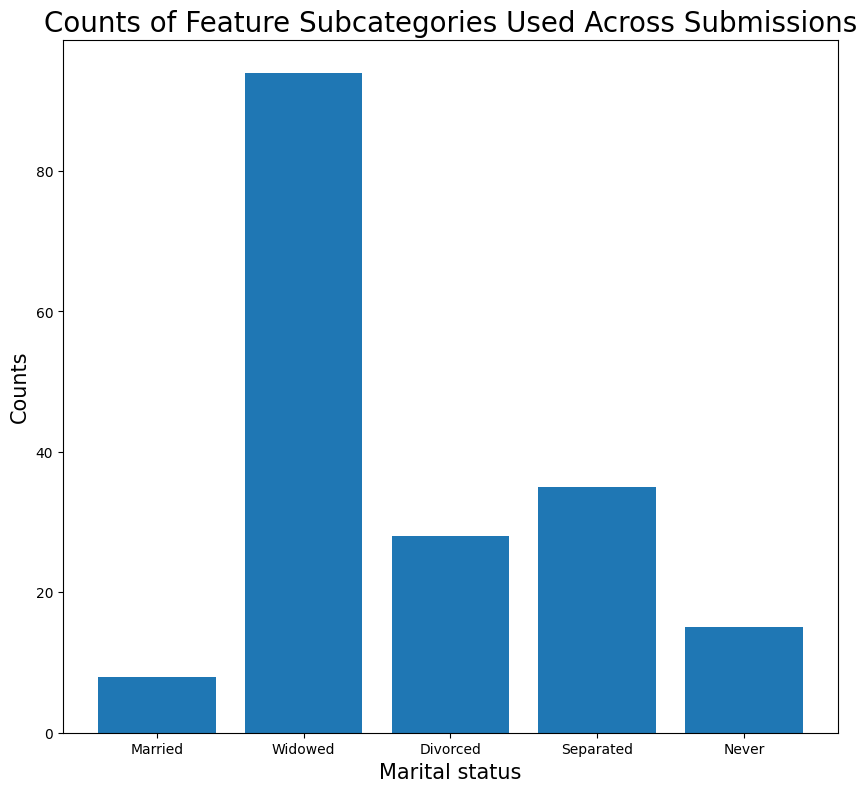

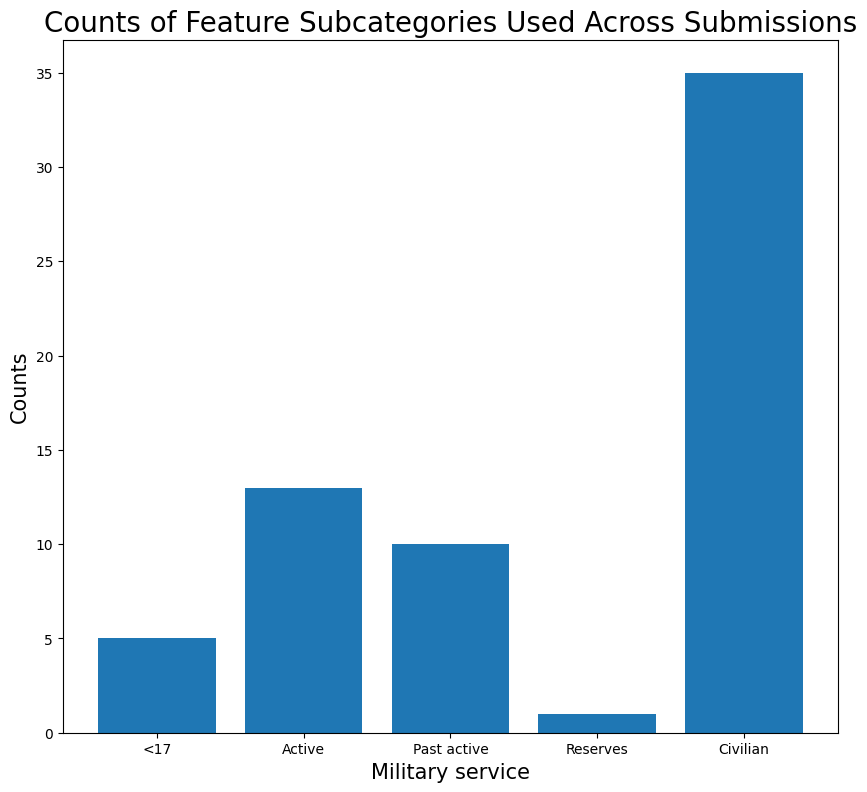

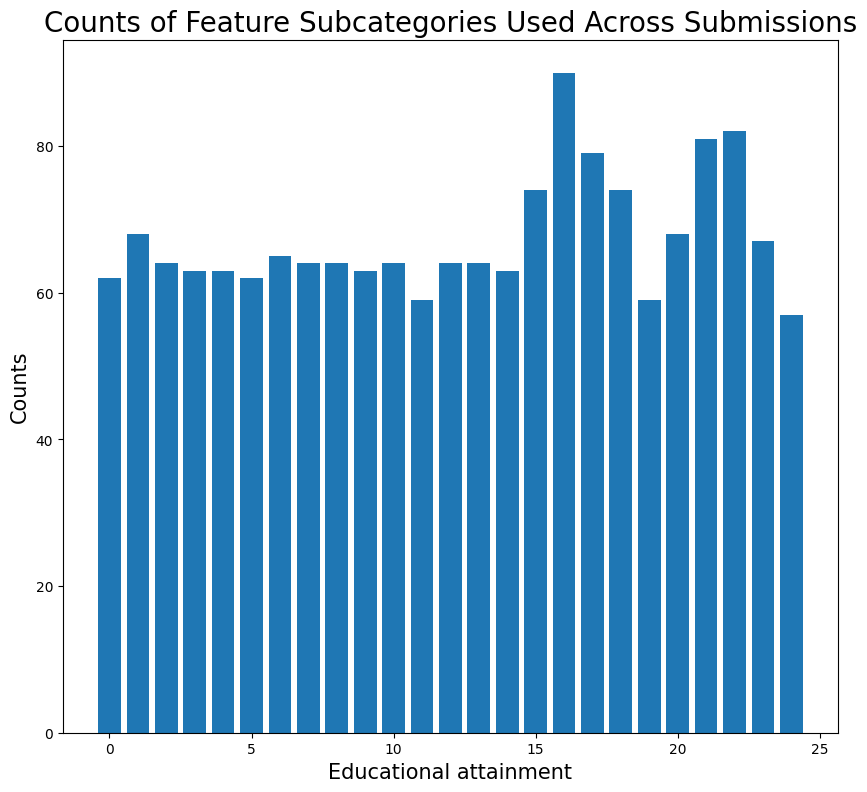

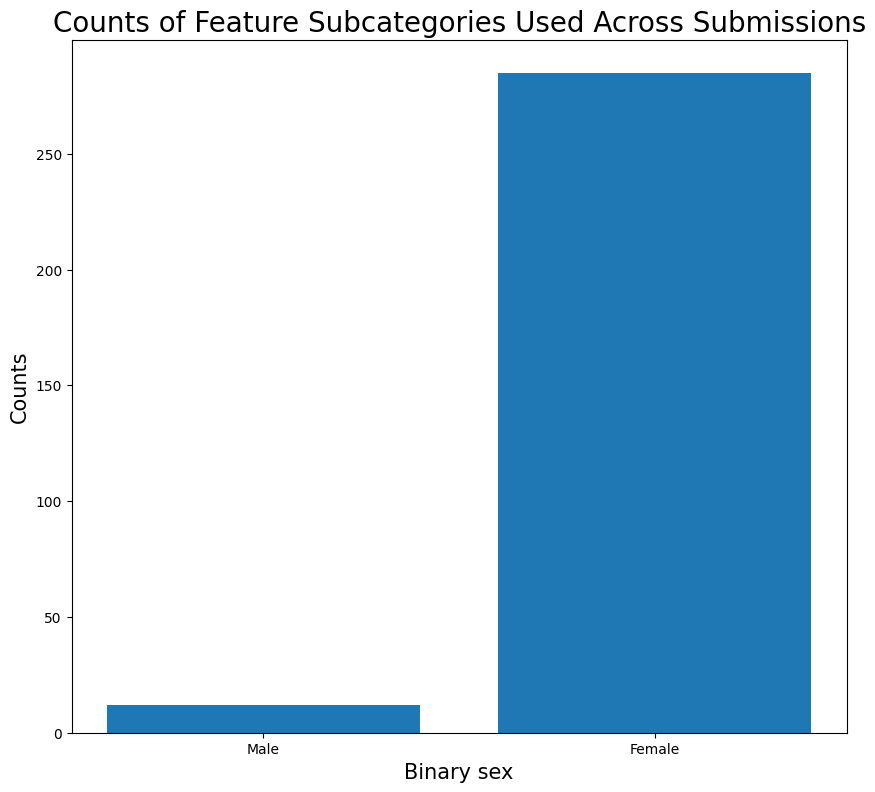

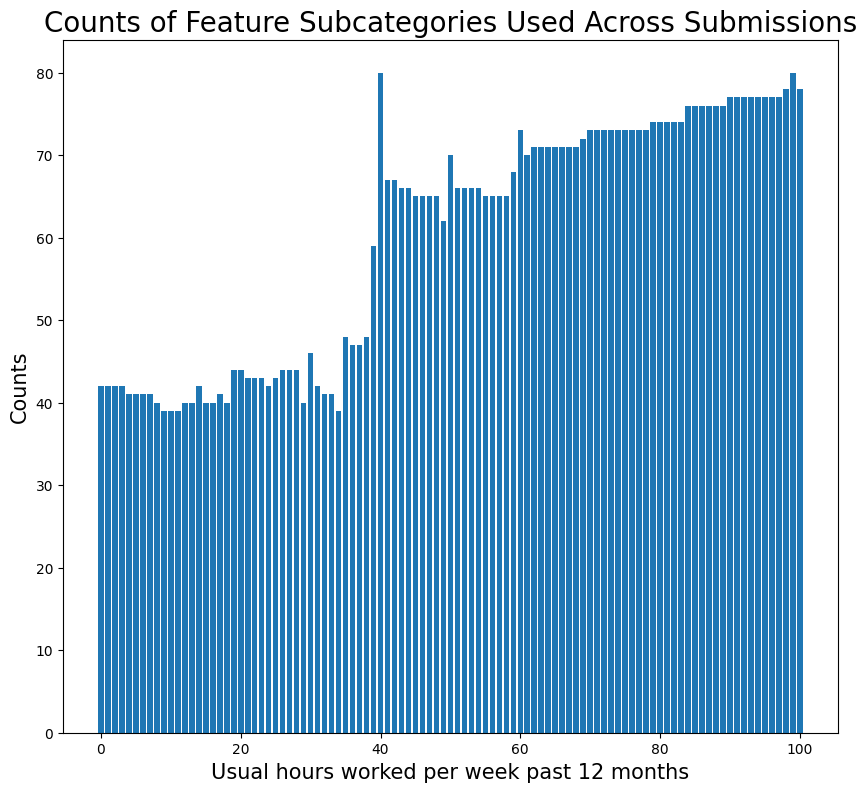

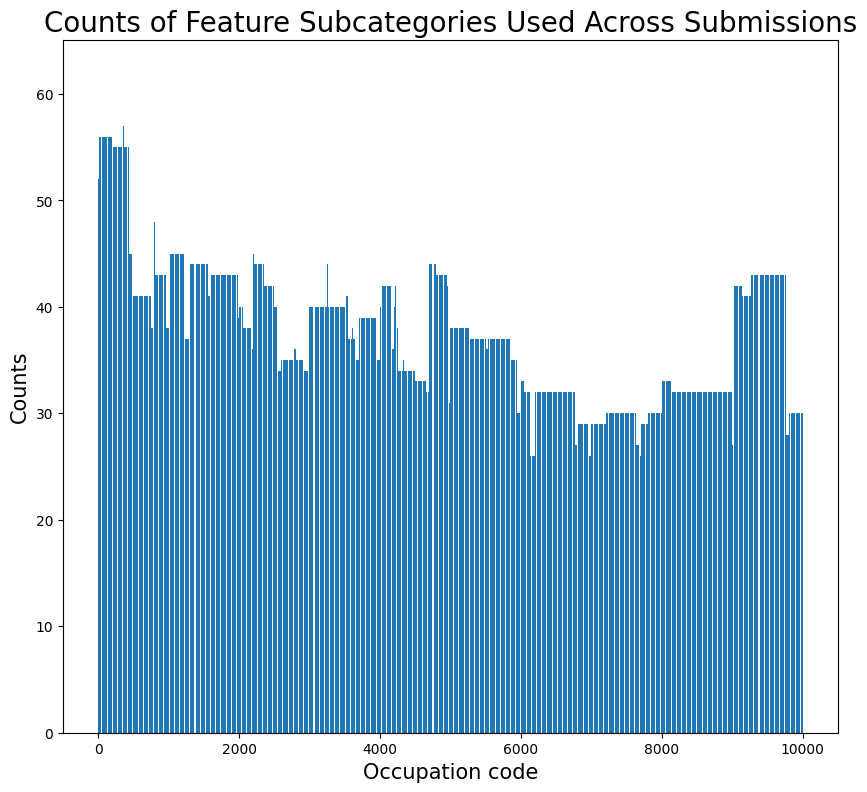

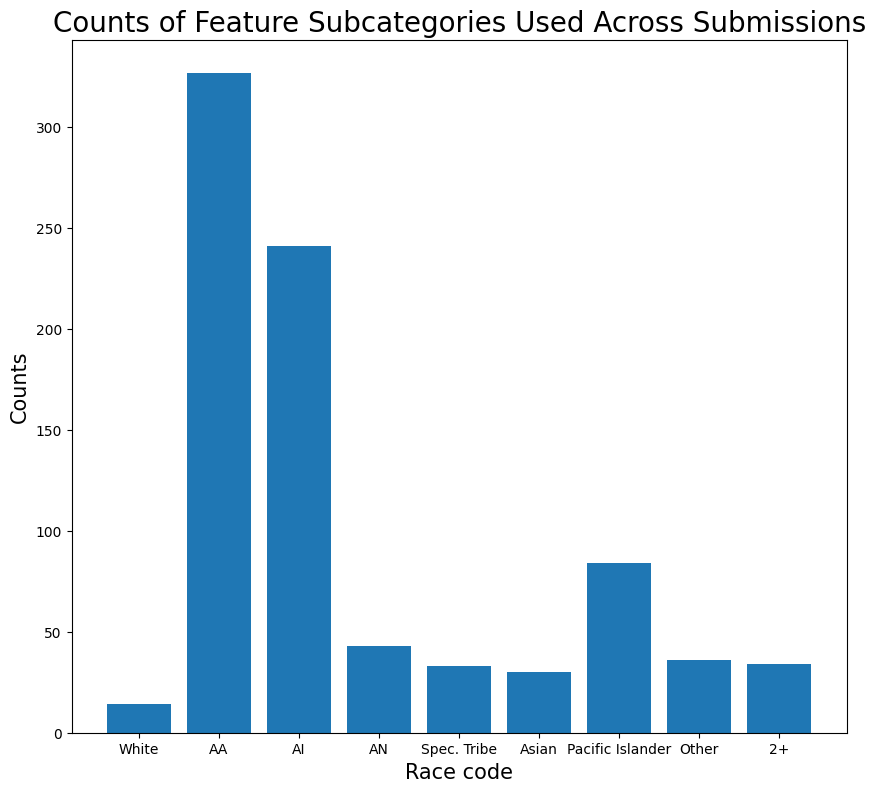

In [12]:
# count per feature category

for feature in features:
    
    #fig = plt.figure(figsize=(17,10))
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    if feature.catNames is not None:
        plt.bar(feature.catNames, np.sum(feature.visArray, axis=0))
    elif feature.featureName=='ST':
        plt.bar(np.arange(57),np.sum(feature.visArray, axis=0))
    else:
        plt.bar(np.arange(len(feature.cats)),np.sum(feature.visArray, axis=0))
    plt.xlabel(feature.description, fontsize='15')
    plt.ylabel('Counts',fontsize='15');
    plt.title('Counts of Feature Subcategories Used Across Submissions', fontsize=20)

    if feature.catNames is not None:
        plt.xticks(ticks=np.arange(len(feature.catNames)), labels=feature.catNames);

    #blue_patch = mpatches.Patch(color='tab:blue', label='Region of feature space specified')
    #gray_patch = mpatches.Patch(color='tab:gray', label='Demarcation between teams')

    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

    # Put a legend below current axis
    # ax.legend(handles=[blue_patch, gray_patch], loc='upper center', bbox_to_anchor=(0.5, -0.1),
    #         fancybox=True, shadow=True, ncol=5)

    plt.savefig('fig/featurevis/%scounts.png'%feature.featureName)

One thing you can see from the above plots is that not all feature selection makes sense. For instance, a lot of groups marginalize specifically on people under the age of 5, not looking at the feature age but on other features where one of the categories is a "not applicable" that would mean an individual in that group is a minor. Below, we compute the number of groups that do this.

In [18]:
# looking at all the features where minors are one of the categories

minors_included = [cow, ddrs, dout, drem, eng, mil]
tally=0
for feature in minors_included:
    tally+=np.sum(feature.visArray[:,0])

print(f"%i submitted groups look at young minors." %tally)

53 submitted groups look at young minors.


Similarly, people made strange choices when marginalizing over hearing loss

In [27]:
print(np.sum(dear.visArray, axis=0)) # sum of categories

data[data["DEAR"]==True].reset_index(drop=True)["TID"].nunique() #number of teams who considered the category

[ 0. 95.]


22

We can also look at the breakdown of which features were used overall across the submissions.

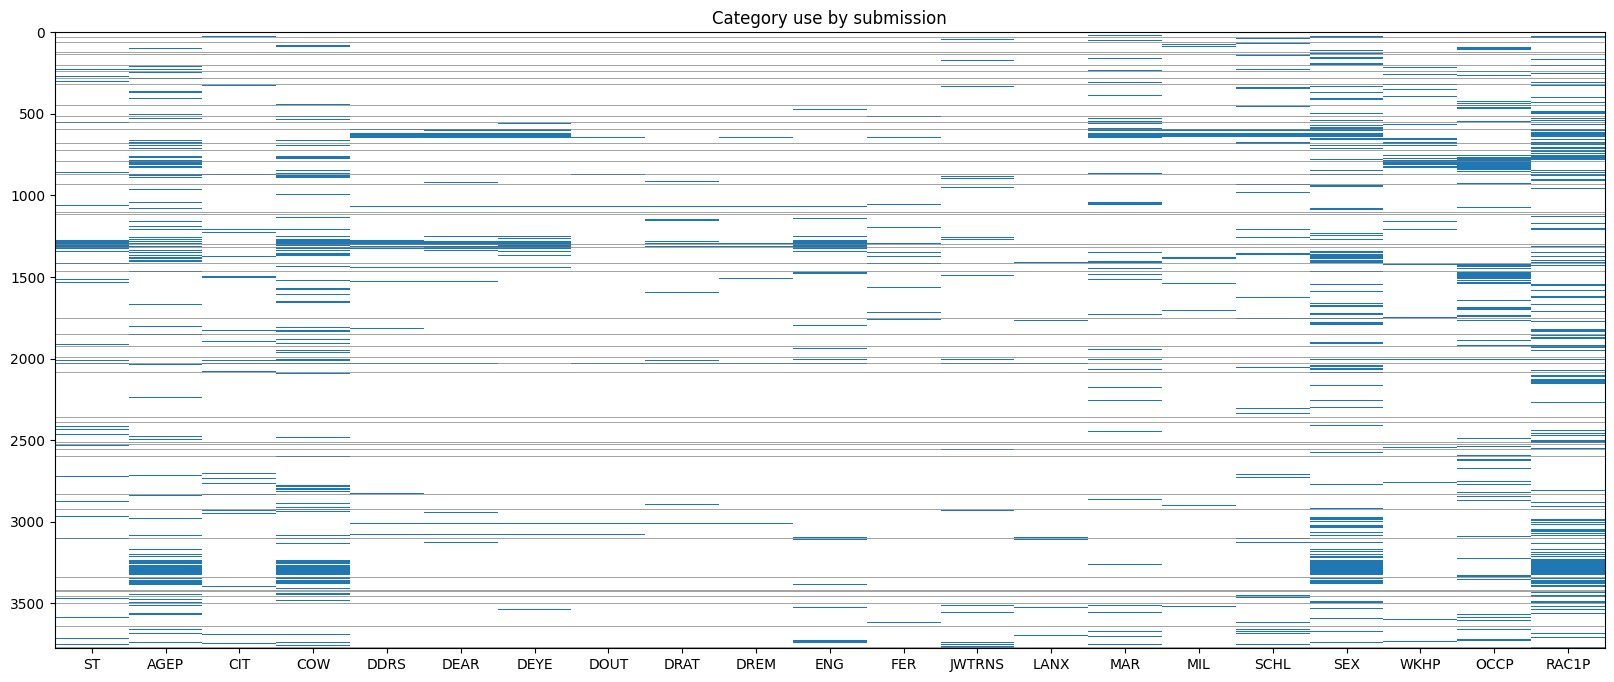

<Figure size 2000x800 with 0 Axes>

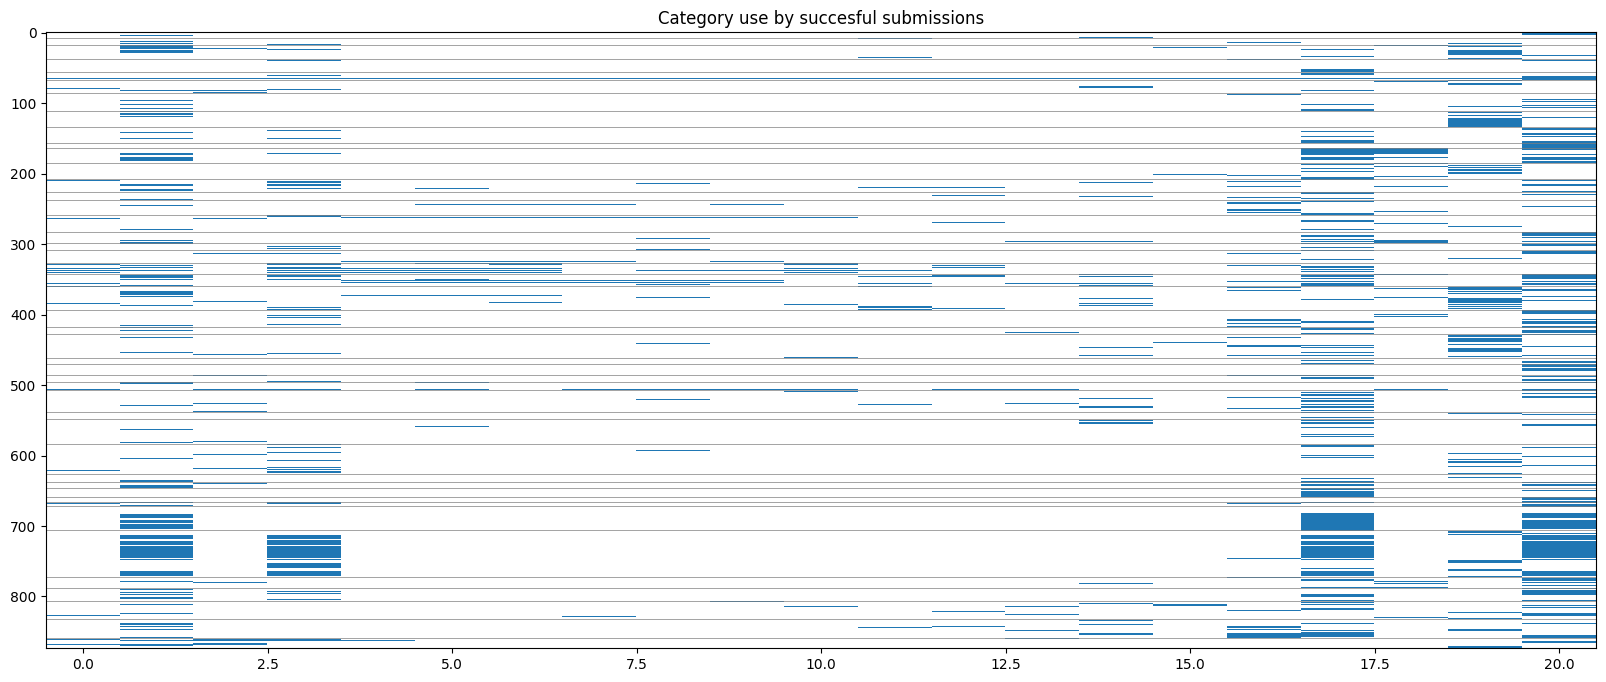

In [30]:
allfeatureVis = np.zeros((len(data), len(featureColumns)))
for i in range(len(featureColumns)):
    allfeatureVis[:,i] = data[featureColumns[i]]

groupBoundaries = data[~data.duplicated(subset='TID', keep='last')].index

fig = plt.figure()
ax = plt.subplot(111)
[ax.axhline(y=b, color='tab:gray', linewidth=0.5) for b in groupBoundaries]
ax.imshow(allfeatureVis, cmap=cmap, aspect='auto', interpolation='nearest')
plt.xticks(ticks=np.arange(0,21), labels=featureColumns);
plt.title('Category use by submission');
plt.savefig("fig/featurevis/all-cat.png")
plt.show();
plt.clf();

acceptedData = data[(data['TF']==True) | (data['GF']==True)]
acceptedData = acceptedData.reset_index(drop=True)
acceptedfeatureVis = np.zeros((len(acceptedData), len(featureColumns)))
groupBoundaries = acceptedData[~acceptedData.duplicated(subset='TID', keep='last')].index


for i in range(len(featureColumns)):
    acceptedfeatureVis[:,i] = acceptedData[featureColumns[i]]

fig = plt.figure();
ax = plt.subplot(111);
[ax.axhline(y=b, color='tab:gray', linewidth=0.5) for b in groupBoundaries]
plt.imshow(acceptedfeatureVis, cmap=cmap, aspect='auto', interpolation='nearest');
plt.title("Category use by succesful submissions");
plt.savefig("fig/featurevis/succ-cat.png")

## Complexity and size of groups developed

The above plots look at how individual features are represented by the groups. It could be that the groups that people came up with only looked at a single feature at a time, or they could be more complex and marginalize across many features simultaneously. The number of features used is in some sense a representation of complexity of the groups, so we look at that here. Most teams stuck to 1 or 2 features per group.

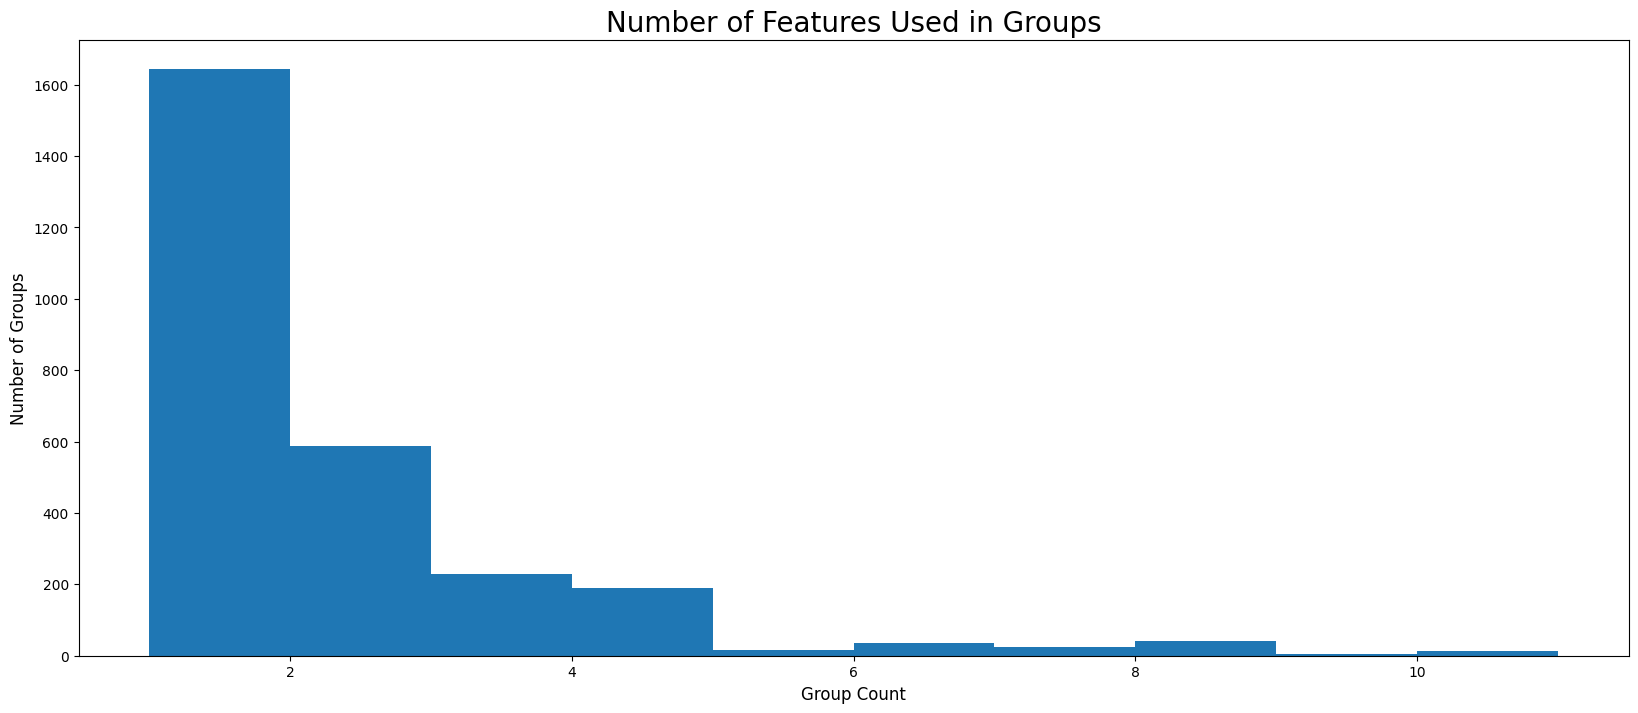

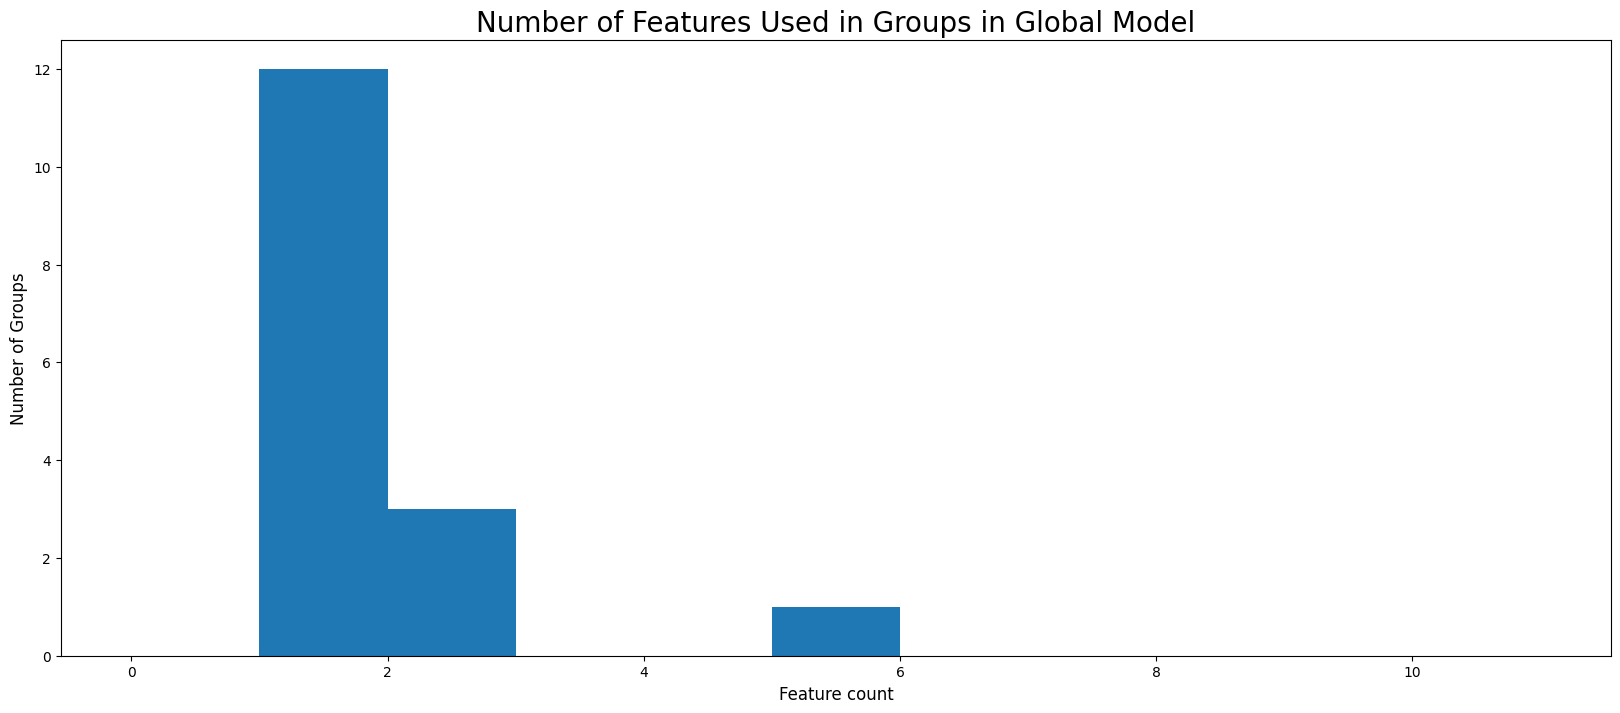

Maximum number of features used: 21
Correlation between number of features used and acceptance -0.04852620605742413
Acceptance rate for groups with 1-3 features used: 0.26420129622569577
Acceptance rate for groups with more than 3 features used: 0.2084592145015106


In [117]:
# looking at number of features per group function

featureNames = [feature.featureName for feature in features]
numFeaturesUsed = data[data['GrCo']!='automatic'][featureNames].sum(axis=1)
counts, bins = np.histogram(numFeaturesUsed, np.arange(12))
plt.stairs(counts[1:], bins[1:], fill=True) ## NOTE: omitting the bin of 0-feature groups, which were due to parsing errors. So not quite the whole story here.
plt.ylabel('Number of Groups', fontsize=12)
plt.xlabel('Group Count', fontsize=12)
plt.title('Number of Features Used in Groups', fontsize=20)
plt.savefig("fig/nFeaturesAllGroups.png")
plt.show()
plt.clf()

# looking at same thing but just for the global model 

featureNames = [feature.featureName for feature in features]
numFeaturesUsedG = data[(data['GrCo']!='automatic') & data['GF']==True][featureNames].sum(axis=1)
plt.hist(numFeaturesUsedG, np.arange(12))
plt.ylabel('Number of Groups', fontsize=12)
plt.xlabel('Feature count', fontsize=12)
plt.title('Number of Features Used in Groups in Global Model', fontsize=20)
plt.savefig("nFeaturesGlobalGroups.png")
plt.show()

# max features used
print("Maximum number of features used:", np.max(numFeaturesUsed))

# correlation between # features and acceptance
print("Correlation between number of features used and acceptance", numFeaturesUsed.corr(accepted_flag))

# rate of acceptance for groups w 1-3 features used
simple_groups = data[data['GrCo']!='automatic'][numFeaturesUsed<=3]
print("Acceptance rate for groups with 1-3 features used:", ((simple_groups['TF']==True) | (simple_groups['GF']==True)).sum()/len(simple_groups))

# rate of acceptance for groups w more features used
complex_groups = data[data['GrCo']!='automatic'][numFeaturesUsed>3]
print("Acceptance rate for groups with more than 3 features used:", ((complex_groups['TF']==True) | (complex_groups['GF']==True)).sum()/len(complex_groups))

Another measure of specificity in the groups is how much of the distribution was captured in that group. Plotting group weights, we see that teams in general chose groups that were not overly small.

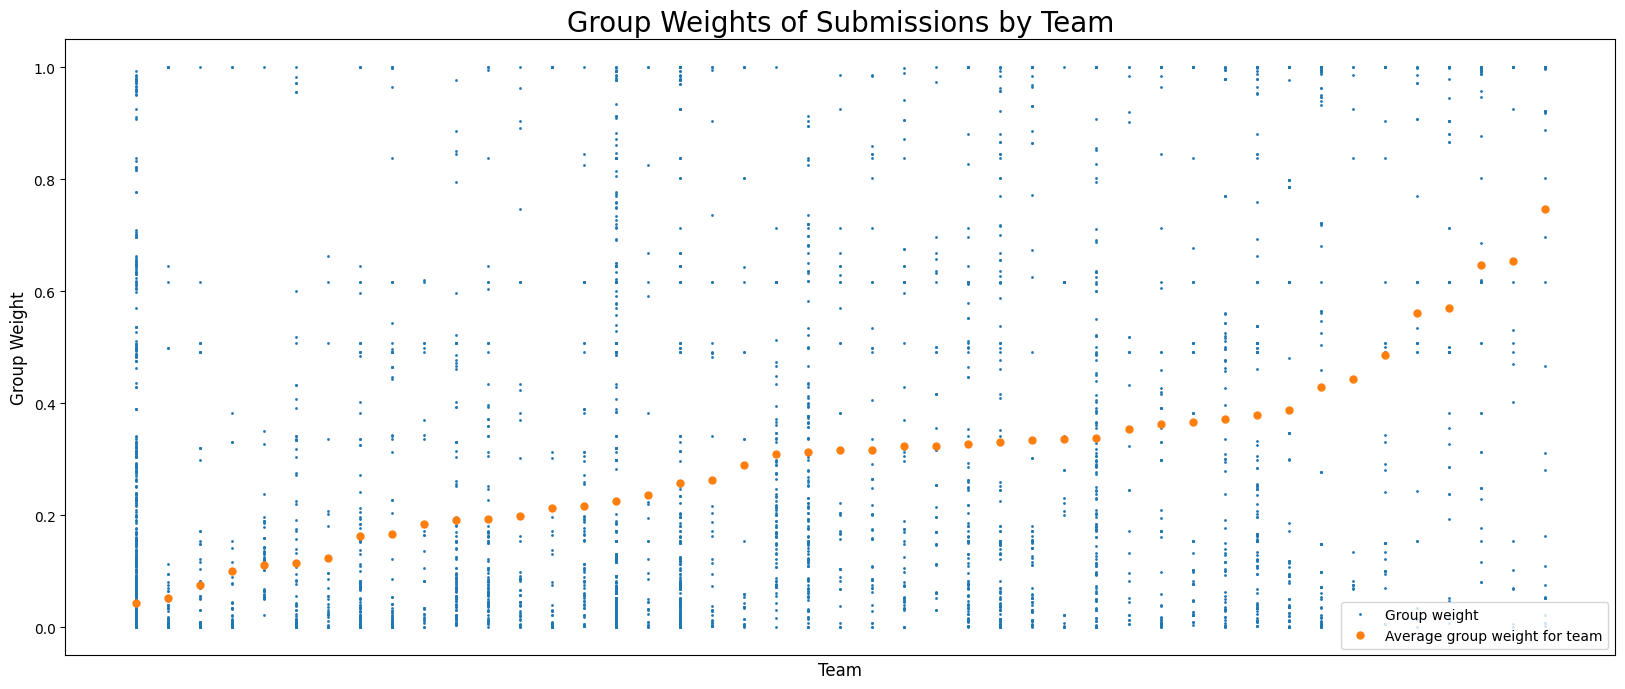

In [31]:
# distribution across teams of group weights

nteams = 45

# get average group weight per team
averageWeights = np.array([np.mean(alldata[alldata['TID']==i]['GrWTe']) for i in range(45)])

#get order of teams sorted by average submitted group weight
teamsSorted = np.argsort(averageWeights)

for i in range(0, nteams):
    if i == 0: 
        plt.plot(i*np.ones(sum(alldata['TID']==teamsSorted[i])), alldata[alldata['TID']==teamsSorted[i]]['GrWTe'], 'o', markersize=1, color='tab:blue', label='Group weight')
    else:
        plt.plot(i*np.ones(sum(alldata['TID']==teamsSorted[i])), alldata[alldata['TID']==teamsSorted[i]]['GrWTe'], 'o', markersize=1, color='tab:blue')
    #plt.boxplot([data[data['TID']==i]['GrWTe'] for i in range(nteams)], 'o')

plt.plot(np.arange(nteams), averageWeights[teamsSorted], 'o', color='tab:orange', markersize=5, label='Average group weight for team')    

#get order of teams sorted by average submitted group weight
teamsSorted = np.argsort([np.mean(alldata[alldata['TID']==i]['GrWTe']) for i in range(nteams)])

plt.title('Group Weights of Submissions by Team', fontsize=20)
plt.ylabel('Group Weight', fontsize=12)
plt.xlabel('Team', fontsize=12)
plt.xticks([])
plt.legend();
plt.savefig('fig/weights_by_team.png')


Did specificity help? Not entirely. 

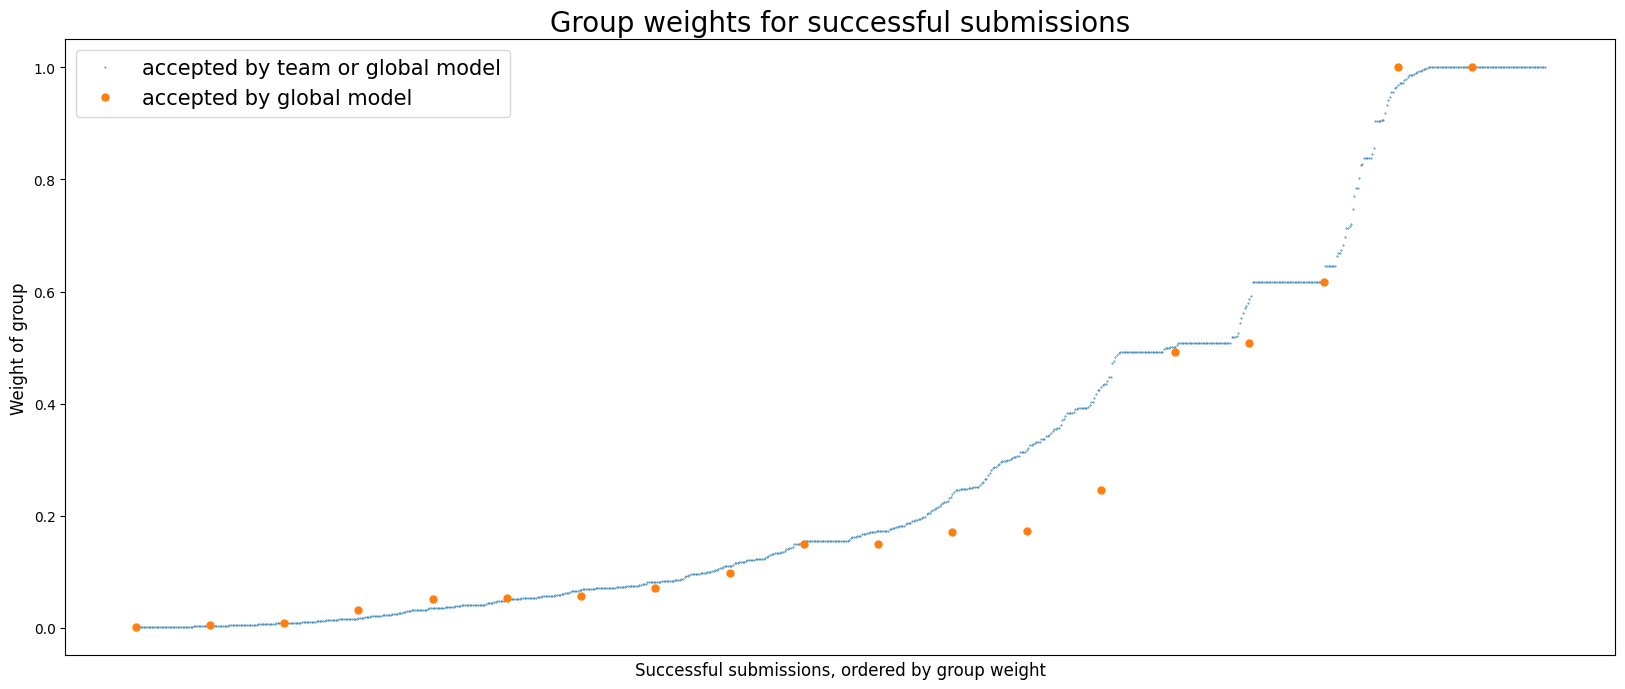

In [32]:
# distribution of group weights

plt.plot(np.arange(len(data[accepted_flag])), np.sort(data[accepted_flag]['GrWTe']), 'o', markersize=0.4, label='accepted by team or global model')
offset = len(data[accepted_flag])/len(data[data['GF']==True])
xs = np.arange(0, len(data[accepted_flag]), offset)
plt.plot(xs, np.sort(data[data['GF']==True]['GrWTe']), 'o', markersize=5, label='accepted by global model')
plt.ylabel('Weight of group', fontsize=12)
plt.xlabel('Successful submissions, ordered by group weight', fontsize=12)
plt.title('Group weights for successful submissions', fontsize=20)
plt.xticks([])
plt.legend(fontsize=15)
plt.savefig('fig/group-weights-succ.png')

In [63]:
non_auto_data = data[data['GrCo']!='automatic']

# overall average group weight, ignoring group 7

print("Average group weight, excepting group 7:", np.mean(non_auto_data['GrWTe']))
print("Variance of group weights, excepting group 7:", np.var(non_auto_data['GrWTe']))

# correlations between weight and acceptance

print("Correlation between group weight and acceptance for team models:", non_auto_data['TF'].corr(non_auto_data['GrWTe']))
print("Correlation between group weight and acceptance for global model:", non_auto_data['GF'].corr(non_auto_data['GrWTe']))

# number of large groups
print("%f percent of submitted groups considered at least 50 percent of the dataset but did not consider 100 percent and were submitted by %d of the teams"%(sum((non_auto_data['GrWTe']>=0.5) & (non_auto_data['GrWTe']<1.0))/len(non_auto_data), non_auto_data[(non_auto_data['GrWTe']>=0.5) & (non_auto_data['GrWTe']<1.0)]['TID'].value_counts().nunique()))
print("Number of groups that were over all dataset was", sum(non_auto_data['GrWTe']==1.0))
print("Number of teams who attempted to make an update across the entire dataset:", non_auto_data[non_auto_data['GrWTe']==1.0]['TID'].value_counts().nunique())

Average group weight, excepting group 7: 0.2832686787693847
Variance of group weights, excepting group 7: 0.1135119392500986
Correlation between group weight and acceptance for team models: 0.0552706813625917
Correlation between group weight and acceptance for global model: 0.001048028123857732
0.183142 percent of submitted groups considered at least 50 percent of the dataset but did not consider 100 percent and were submitted by 22 of the teams
Number of groups that were over all dataset was 216
Number of teams who attempted to make an update across the entire dataset: 15


It could be that groups submitted earlier by teams were larger, and then as the model they were competing against got better, their groups became more specific. Is this the case? For the global model, we can see that some of the later updates did constitute substantial portions of the dataset; notably the 12th and 14th updates are over the entire dataset. 

In [36]:
np.array(data[data['GF']==True]['GrCo'])
data[data['GF']==True]['GrWTe']

516     0.171281
511     0.149823
159     0.030760
2301    0.001084
17      0.051080
18      0.056636
19      0.148712
20      0.005049
21      0.052493
15      0.508259
13      0.071289
577     1.000000
337     0.491741
574     1.000000
55      0.616415
1204    0.172351
1260    0.009042
755     0.096795
133     0.246275
Name: GrWTe, dtype: float64

What did these submissions that were accepted to the global model and were over the entire dataset look like? 

In [66]:
data[(data['GF']==True) & (data['GrWTe']==1.0)]['TID']
# TID = 21, 24



577    21
574    24
Name: TID, dtype: int64

## Analyzing automated vs manual groups

In [39]:
# percentage of submissions that were automated
print("Percentage of submissions that were automated:", sum(data['GrCo']=='automatic')/len(data))

# success rate of submissions that were automated 
print("Success rate of automated submissions:", sum(((data["TF"]==True) | (data["GF"]==True)) & (data['GrCo']=='automatic'))/sum(data['GrCo']=='automatic'))

# number of global updates that were automated
print("Number of global updates that were automated:", sum((data['GF']==True) & (data['GrCo']=='automatic')))

# which ones were they and how much weight did they have?
print("Which updates were automated and what were their group weights for global model?")
print(data[(data['GF']==True) & (data['GrCo']=='automatic')][['GU', 'GrWTe']])

# success rate of manual submissions
print("Success rate of manual submissions:", sum(((data["TF"]==True) | (data["GF"]==True)) & (data['GrCo']!='automatic'))/sum(data['GrCo']!='automatic'))

Percentage of submissions that were automated: 0.21789780248874768
Success rate of automated submissions: 0.13608748481166463
Number of global updates that were automated: 3
Which updates were automated and what were their group weights for global model?
        GU     GrWTe
2301  19.0  0.001084
1204  17.0  0.172351
755   16.0  0.096795
Success rate of manual submissions: 0.25795531482735273


## How much of the feature space was used?

Were there areas in the feature space that were not explored? Here we look at this for just the global model.

In [8]:
# reading in the group functions for the global model and evaluating them on the training data

import dill as pkl
import os 
import pandas as pd
import Bias_Bounties_Data.pdl as pdl
import numpy as np
import warnings
warnings.simplefilter('ignore')


# read in training data
x_train = pd.read_csv("Bias_Bounties_Data/data/training_data.csv")
x_test = pd.read_csv("Bias_Bounties_Data/data/test_data.csv")

groupNames = os.listdir("Bias_Bounties_Data/global_pdl/PDL/groups")

group_functions = [pkl.load(open(f'Bias_Bounties_Data/global_pdl/PDL/groups/{group}', 'rb')) for group in groupNames]

coverage = [np.zeros((len(group_functions), len(x_train))), np.zeros((len(group_functions), len(x_test)))]

for i in range(len(group_functions)):
    coverage[0][i,:] = group_functions[i](x_train)
    coverage[1][i,:] = group_functions[i](x_test)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  35 out of  35 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  35 out of  35 | elapsed:    0.1s finished


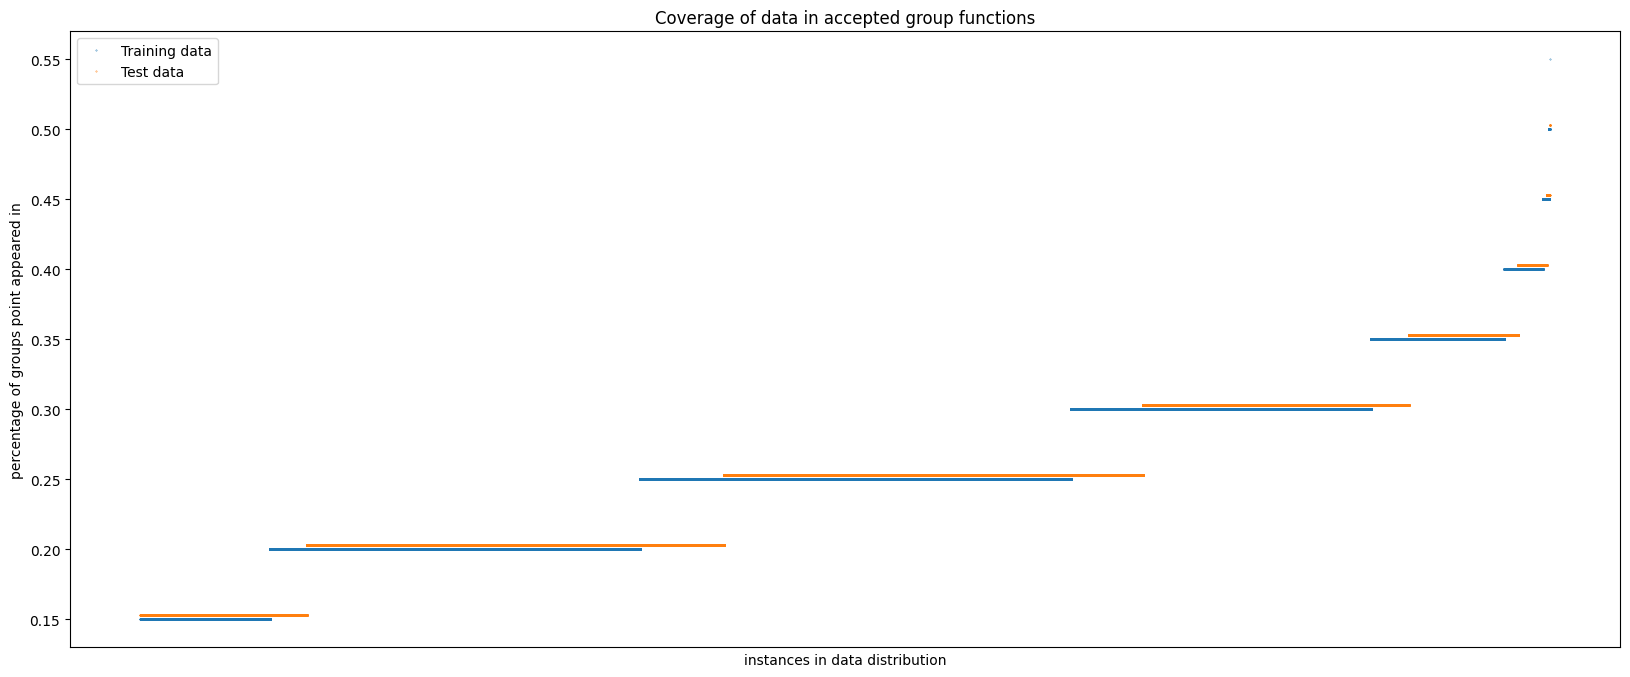

In [175]:
# plotting coverage for training data

training_coverage = np.sort(np.sum(coverage[0], axis=0)/len(group_functions))
plt.plot(np.arange(len(x_train)), training_coverage, 'o', markersize=0.3, label="Training data")

# plot same for test data, rescaling to the same size as training data
vals, counts = np.unique(np.sum(coverage[1], axis=0)/len(group_functions), return_counts=True)
rescaled_counts = np.round(counts * len(x_train)/len(x_test)).astype('int')

rescaled_vals = np.zeros(len(x_train))
start, end = 0,0

for i in range(len(rescaled_counts)):
    end+=rescaled_counts[i]
    rescaled_vals[start:end] = [vals[i]]*(end-start)
    start=end

plt.plot(np.arange(len(x_train)), rescaled_vals+0.003, 'o',  markersize=0.3, label="Test data")
plt.xlabel('instances in data distribution')
plt.ylabel('percentage of groups point appeared in')
plt.title('Coverage of data in accepted group functions')
plt.xticks([])
plt.legend();
plt.savefig('CoverageInData.png')

In [190]:
# percentage of points who only appeared in the groups that covered entire dataset:

x=[]
for val in vals:
    x.append(sum(training_coverage==val)/len(x_train))

[print(vals[i], x[i]) for i in range(len(x))]

sum(x[4:])

0.15 0.09176971428907431
0.2 0.26270528673993193
0.25 0.30598528815114046
0.3 0.21296018627952512
0.35 0.09453039096356142
0.4 0.0271451839569111
0.45 0.004512927258080639
0.5 0.0003880823440173579


0.1265765845225705

## Random Observations

What did the first submissions that teams made look like? Teams in general did not just try to optimize their local models as a first step, which probably would have been a fairly succesful approach.

In [64]:
nteams = 45

teams_initial_submissions = [data.iloc[data[data["TID"]==i]["GAN"].argmin()] for i in range(nteams) if i != auto_team]
teams_initial_accepted_submissions = [data.iloc[data[((data["TID"]==i) & (data["TF"]==1.0))]["GAN"].argmin()] for i in range(nteams) if i != auto_team]

print('initial submissions weight: ', np.sort([teams_initial_submissions[i]["GrWTe"] for i in range(len(teams_initial_submissions))]))
print('initial accepted submissions weight: ', np.sort([teams_initial_accepted_submissions[i]["GrWTe"] for i in range(len(teams_initial_submissions))]))

max_weight_index = np.argmax([teams_initial_accepted_submissions[i]["GrWTe"] for i in range(len(teams_initial_accepted_submissions))])
teams_initial_accepted_submissions[max_weight_index]["GrCo"]
teams_initial_accepted_submissions[max_weight_index]["TID"] 


initial submissions weight:  [5.48802239e-05 7.57347090e-03 3.18305299e-02 3.18305299e-02
 4.01723239e-02 4.01723239e-02 7.08366490e-02 7.09052493e-02
 8.51878276e-02 8.51878276e-02 8.51878276e-02 8.73144362e-02
 9.69870757e-02 1.07674999e-01 1.07674999e-01 1.09582087e-01
 1.13547183e-01 1.73407788e-01 1.73407788e-01 1.76261559e-01
 2.01931784e-01 2.19520896e-01 2.49855939e-01 2.64893121e-01
 2.64893121e-01 2.64893121e-01 2.91825591e-01 4.06881980e-01
 4.06881980e-01 4.91740526e-01 4.91740526e-01 4.99560958e-01
 5.35576105e-01 5.35576105e-01 6.16414675e-01 6.36692918e-01
 8.37472217e-01 8.37472217e-01 8.45567050e-01 8.45567050e-01
 8.60124029e-01 8.60124029e-01 9.85580221e-01 1.00000000e+00]
initial accepted submissions weight:  [3.29281343e-04 3.29281343e-04 6.33729386e-02 6.33729386e-02
 6.33729386e-02 6.33729386e-02 6.33729386e-02 6.33729386e-02
 7.08366490e-02 7.08366490e-02 7.57621491e-02 7.57621491e-02
 7.57621491e-02 7.57621491e-02 7.57621491e-02 7.57621491e-02
 7.57621491e-02 8

0

# Automated versus Manual Submissions

In [38]:
print("Number of automatic updates accepted into global model:", sum((data['GrCo']=='automatic') & (data['GF']==True)))
print("Number of global updates", sum(data['GF']==True))
print("Number of total automatic updates over total updates", sum(data['GrCo']=='automatic')/len(data))
print("Rate of acceptance for automatic updates", sum((data['GrCo']=='automatic') & ((data['TF']==True) | (data['GF']==True)))/sum(data['GrCo']=='automatic'))
print("Rate of acceptance for manual updates", sum((data['GrCo']!='automatic') & ((data['TF']==True) | (data['GF']==True)))/sum(data['GrCo']!='automatic'))
print("Number of teams who attempted automated submissions: %d out of %d " %(len(data[data['GrCo']=='automatic']['TID'].value_counts()), nteams))

Number of automatic updates accepted into global model: 3
Number of global updates 19
Number of total automatic updates over total updates 0.21789780248874768
Rate of acceptance for automatic updates 0.13608748481166463
Rate of acceptance for manual updates 0.25795531482735273
Number of teams who attempted automated submissions: 37 out of 45 


## Build figures into a teX doc

In [ ]:
import pdfHandling
import importlib
importlib.reload(pdfHandling)
pdfHandling.buildLatexDoc('fig/featurevis/', 'groupAnalysis', 'Analysis of Submitted Groups')

## Basic numbers used in paper

In [106]:
# number of groups that use race for g
print("total number of groups predicating on race", sum(data["RAC1P"]))

# counts of each subcategory
print(rac1p.catNames)
np.sum(rac1p.visArray, axis=0)

# number of groups that predicated over women
print("sex counts")
print(np.sum(sex.visArray, axis=0))
print("ratio female/total", np.sum(sex.visArray, axis=0)[1]/np.sum(sex.visArray))

# number of features used by manual updates
print("number of manual updates", len(data[data['GrCo']!='automatic']))
print("number of manual updates using 2 features", sum(numFeaturesUsed[numFeaturesUsed==2]))
len(data[data['GrCo']!='automatic'])
print("number of manual updates using 2 features / number of manual updates", sum(numFeaturesUsed==2)/len(data[data['GrCo']!='automatic']))
print("number of groups w 0 features due to parsing errors", sum(numFeaturesUsed==0))
print("percentage of manual updates which used 3 or less features", sum((numFeaturesUsed<=3) & (numFeaturesUsed>0))/(len(data[data['GrCo']!='automatic'])))

total number of groups predicating on race 821
['White', 'AA', 'AI', 'AN', 'Spec. Tribe', 'Asian', 'Pacific Islander', 'Other', '2+']
sex counts
[ 12. 285.]
ratio female/total 0.9595959595959596
number of manual updates 2954
number of manual updates using 2 features 1178
number of manual updates using 2 features / number of manual updates 0.1993906567366283
number of groups w 0 features due to parsing errors 162
percentage of manual updates which used 3 or less features 0.8331076506431957
